# Skills Mismatch Analysis
## Copyright © 2025 Angel Lanto. All rights reserved.

### This code is part of a skills mismatch analysis project and is intended for academic, research, or portfolio use. No part of this code may be reproduced, distributed, or used in commercial applications without explicit permission from the author.

### Author: Angel Lanto
### Year: 2025


# Libraries

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving standardized-20160314skillsmismatchref.xls to standardized-20160314skillsmismatchref.xls


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
from functools import reduce

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Data Exploration & Pre-Processing

In [ ]:
# -------------------------------------------------
# 1. Read and Clean the Excel Sheets
# -------------------------------------------------
# Define the file path for the standardized dataset
file_path = 'standardized-20160314skillsmismatchref.xls'

# Load all sheets from the Excel file into a dictionary (xlrd engine for .xls files)
sheets_dict = pd.read_excel(file_path, sheet_name=None, engine='xlrd')

# Dictionary to store processed DataFrames for further use if needed
processed_sheets = {}

# Mapping for month range (as extracted) to quarter token
month_to_quarter = {
    'Jan-Mar': 'Q1',
    'Apr-Jun': 'Q2',
    'Jul-Sep': 'Q3',
    'Oct-Dec': 'Q4'
}

# Process every sheet from the Excel file
for sheet_name, df in sheets_dict.items():
    print(f"\n\n--- Processing sheet: '{sheet_name}' ---")

    # 1. Basic Exploration & Info (Optional: for debugging)
    print("Original Dataset Shape:", df.shape)
    print("\nFirst five rows:")
    print(df.head())
    print("\nDataset Info:")
    print(df.info())
    print("\nStatistical Summary:")
    print(df.describe(include='all'))

    # 2. Data Quality Checks: Missing values & duplicates.
    print("\nMissing Values per Column:")
    print(df.isnull().sum())
    duplicates = df.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicates}")

    # 3. Data Pre-processing: Drop missing and duplicate rows.
    df_clean = df.dropna()
    print(f"\nAfter dropping missing values, new shape: {df_clean.shape}")
    df_clean = df_clean.drop_duplicates()
    print(f"After dropping duplicates, new shape: {df_clean.shape}")

    # 4. Standardize column names: trim, lowercase, replace spaces with underscores.
    df_clean.columns = [col.strip().lower().replace(' ', '_') for col in df_clean.columns]
    print("\nColumns after renaming:")
    print(df_clean.columns)

    # 5. Replace ":" in potential numeric (object) columns and convert to numeric.
    potential_numeric_cols = []
    for col in df_clean.columns:
        if df_clean[col].dtype == object:
            # Mark as potential numeric if any digit or colon is found
            if df_clean[col].str.contains(r'\d|:', na=False).any():
                potential_numeric_cols.append(col)

    for col in potential_numeric_cols:
        df_clean[col] = df_clean[col].astype(str).str.replace(":", "0")
        try:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='raise')
            print(f"Column '{col}' successfully converted to numeric.")
        except Exception as e:
            print(f"Column '{col}' could not be fully converted to numeric. Error: {e}")

    # 6. Rename first four numeric columns (if available) to matched, overeducated, undereducated, total.
    numeric_cols = df_clean.select_dtypes(include='number').columns.tolist()
    if len(numeric_cols) >= 4:
        rename_map = {
            numeric_cols[0]: 'matched',
            numeric_cols[1]: 'overeducated',
            numeric_cols[2]: 'undereducated',
            numeric_cols[3]: 'total'
        }
        df_clean.rename(columns=rename_map, inplace=True)
        print("\nRenamed numeric columns:")
        for old, new in rename_map.items():
            print(f"  {old} -> {new}")
    else:
        print("\nWarning: Fewer than 4 numeric columns found. Adjust renaming as needed.")

    # 7. Process the 'quarter' column: extract the year and derive quarter token.
    if 'quarter' in df_clean.columns:
        df_clean['quarter'] = df_clean['quarter'].astype(str)
        df_clean['year'] = df_clean['quarter'].str.extract(r'(\d{4})')
        month_pattern = (
            r'(Jan\s*-\s*Mar|'
            r'Apr\s*-\s*Jun(?:e)?|'
            r'Jul\s*-\s*Sep|'
            r'Oct\s*-\s*Dec)'
        )
        df_clean['extracted_month_range'] = df_clean['quarter'].str.extract(month_pattern, expand=False)
        df_clean['extracted_month_range'] = (
            df_clean['extracted_month_range']
            .str.replace(r'June', 'Jun', regex=False)
        )
        df_clean['extracted_month_range'] = (
            df_clean['extracted_month_range']
            .str.replace(r'[\s-]+', '-', regex=True)
            .str.strip('-')
        )
        df_clean['quarter_mapped'] = df_clean['extracted_month_range'].map(month_to_quarter)

        print("\nFrom 'quarter' column, extracted 'year', 'extracted_month_range', and 'quarter_mapped':")
        print(df_clean[['quarter', 'year', 'extracted_month_range', 'quarter_mapped']].head())

    # 8. Reset index after cleaning
    df_clean.reset_index(drop=True, inplace=True)

    # Display summary of the cleaned data
    print("\nCleaned Dataset Shape:", df_clean.shape)
    print("First five rows of the cleaned dataset:")
    print(df_clean.head())

    # Store the processed sheet for further analysis
    processed_sheets[sheet_name] = df_clean

print("\nAll sheets have been processed and cleaned.")



--- Processing sheet: 'Whole economy' ---
Original Dataset Shape: (55, 5)

First five rows:
        Quarter  Matched  Overeducated  Undereducated  Total
0  Apr-Jun 2002     67.4          15.1           17.4    100
1  Jul-Sep 2002     67.8          14.9           17.3    100
2  Oct-Dec 2002     68.3          14.8           17.0    100
3  Jan-Mar 2003     68.5          14.6           16.9    100
4  Apr-Jun 2003     68.7          14.4           16.8    100

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Quarter        55 non-null     object 
 1   Matched        55 non-null     float64
 2   Overeducated   55 non-null     float64
 3   Undereducated  55 non-null     float64
 4   Total          55 non-null     int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 2.3+ KB
None

Statistical Summary:
             Quarter    Ma

-- This block is responsible for reading and cleaning all sheets within the Excel file, which contains data on skills mismatch across various demographic and employment categories. Using the xlrd engine, it loads each sheet into a dictionary of DataFrames. Each sheet is then processed individually through a series of steps to ensure data quality and consistency. Initially, the script prints basic information including the shape, sample rows, missing values, and statistical summaries to allow for preliminary exploration and debugging. It then removes any rows with missing values or duplicates to ensure that the dataset is clean and reliable. Column names are standardized by converting them to lowercase, trimming whitespaces, and replacing spaces with underscores, which improves readability and ensures consistency during analysis.

Next, the script identifies and cleans columns that may contain numeric values masked as strings or with placeholder symbols like “:”, converting them into numeric types where possible. It then renames the first four numeric columns—presumed to represent matched, overeducated, undereducated, and total—to standardize key indicators used in skills mismatch analysis. If a quarter column is available, the script extracts the year and maps the month range to standard quarterly tokens (Q1–Q4), which allows for temporal analysis. After resetting the index, each cleaned sheet is stored in a dictionary (processed_sheets) for further feature engineering and merging. This structured cleaning pipeline ensures that all data is uniform, analyzable, and ready for downstream processing such as feature extraction, modeling, or visualization. --

# Feature Engineering

In [ ]:
# -------------------------------------------------
# 2. FEATURE ENGINEERING ON CLEANED DATA FROM ALL SHEETS
# -------------------------------------------------
# Assume processed_sheets is the dictionary of cleaned DataFrames.
# For each sheet, we apply feature engineering as needed.

engineered_sheets = {}

for sheet_name, df in processed_sheets.items():
    print(f"\n--- Feature Engineering for Sheet: '{sheet_name}' ---")

    # Example 1: Derived Skill Metrics.
    required_skill_cols = ['matched', 'total', 'overeducated', 'undereducated']
    if all(col in df.columns for col in required_skill_cols):
        # Create ratio: matched/total (handle division by zero).
        df['matched_ratio'] = df.apply(lambda row: row['matched'] / row['total'] if row['total'] != 0 else np.nan, axis=1)
        # Create an education gap measure.
        df['education_gap'] = df['overeducated'] - df['undereducated']

    engineered_sheets[sheet_name] = df
    print(df.head())


--- Feature Engineering for Sheet: 'Whole economy' ---
        quarter  matched  overeducated  undereducated  total  year  \
0  Apr-Jun 2002     67.4          15.1           17.4    100  2002   
1  Jul-Sep 2002     67.8          14.9           17.3    100  2002   
2  Oct-Dec 2002     68.3          14.8           17.0    100  2002   
3  Jan-Mar 2003     68.5          14.6           16.9    100  2003   
4  Apr-Jun 2003     68.7          14.4           16.8    100  2003   

  extracted_month_range quarter_mapped  matched_ratio  education_gap  
0               Apr-Jun             Q2          0.674           -2.3  
1               Jul-Sep             Q3          0.678           -2.4  
2               Oct-Dec             Q4          0.683           -2.2  
3               Jan-Mar             Q1          0.685           -2.3  
4               Apr-Jun             Q2          0.687           -2.4  

--- Feature Engineering for Sheet: 'Gender' ---
        quarter gender  matched  overeducated  u

-- This block of code iterates through all the cleaned DataFrames (processed_sheets), with each one representing a different sheet from the original Excel file. For those sheets that include the necessary columns—namely matched, total, overeducated, and undereducated—the code performs feature engineering by creating two new variables. The first is matched_ratio, which calculates the percentage of individuals whose education level matches their job requirements by dividing the number of matched individuals by the total number in the group. The second is education_gap, which measures the imbalance between overeducated and undereducated individuals by taking the difference between the two values. These transformations are essential because raw data, in its original form, may not readily reveal meaningful patterns. By introducing ratios and gap metrics, the dataset becomes more insightful and better suited for analysis. These engineered features are particularly valuable as they can serve as input variables—or even target variables—in statistical analyses or machine learning models. For example, matched_ratio could be used to predict mismatch likelihood across demographic segments using regression or classification techniques, thereby contributing significantly to understanding and addressing skills mismatch in the labour market. --

In [ ]:
# -------------------------------------------------
# 3. UNION THE ENGINEERED SHEETS (APPEND EACH SHEET)
# -------------------------------------------------
# Here we simply append (concatenate) each sheet while preserving the original column order.
dfs = []

for sheet_name, df in engineered_sheets.items():
    # Create a copy and add the "Sheet Name" column.
    df_copy = df.copy()
    df_copy["Sheet Name"] = sheet_name
    dfs.append(df_copy)

# Concatenate (union) all DataFrames.
merged_df = pd.concat(dfs, ignore_index=True)

# Optionally, reorder columns so that "Sheet Name" appears immediately after "quarter" (if available).
cols = merged_df.columns.tolist()
if "Sheet Name" in cols and "quarter" in cols:
    cols.remove("Sheet Name")
    index_after_quarter = cols.index("quarter") + 1
    cols.insert(index_after_quarter, "Sheet Name")
    merged_df = merged_df[cols]

print("\nMerged DataFrame (first 5 rows):")
print(merged_df.head())


Merged DataFrame (first 5 rows):
        quarter     Sheet Name  matched  overeducated  undereducated  total  \
0  Apr-Jun 2002  Whole economy     67.4          15.1           17.4    100   
1  Jul-Sep 2002  Whole economy     67.8          14.9           17.3    100   
2  Oct-Dec 2002  Whole economy     68.3          14.8           17.0    100   
3  Jan-Mar 2003  Whole economy     68.5          14.6           16.9    100   
4  Apr-Jun 2003  Whole economy     68.7          14.4           16.8    100   

   year extracted_month_range quarter_mapped  matched_ratio  education_gap  \
0  2002               Apr-Jun             Q2          0.674           -2.3   
1  2002               Jul-Sep             Q3          0.678           -2.4   
2  2002               Oct-Dec             Q4          0.683           -2.2   
3  2003               Jan-Mar             Q1          0.685           -2.3   
4  2003               Apr-Jun             Q2          0.687           -2.4   

  gender  age full-tim

-- This block of code consolidates all the engineered DataFrames into a single, unified dataset. It first appends a new column, "Sheet Name", to each DataFrame to identify the original source sheet of each row, preserving the context of the data. The DataFrames are then vertically concatenated using pd.concat(), resulting in one comprehensive DataFrame that combines all the demographic and employment-type variations captured in the individual sheets. This step is necessary because each sheet likely represents a different subset of the population—such as gender, age group, or employment status—and merging them enables cross-sectional and longitudinal analysis across these groups. By bringing all the data together in one place, the merged dataset becomes more practical for unified analyses, model training, and visualization. Moreover, the "Sheet Name" column serves as a useful identifier for segmenting the results later, allowing users to filter or compare trends across various population categories. --

In [ ]:
# -------------------------------------------------
# 4. MERGE COLUMNS L TO P INTO ONE COLUMN
# -------------------------------------------------
# Here we assume that the columns we need to merge are in positions 11 through 15.
# (Adjust the slice indices if your DataFrame's structure is different.)
cols_to_merge = merged_df.columns[11:16]

# Create a new column "Merged_Column" by concatenating the non-null values of these columns.
merged_df["Merged_Column"] = merged_df[cols_to_merge].apply(
    lambda row: ' '.join(row.dropna().astype(str)), axis=1
)

# Rename column if needed
if 'Merged_Column' in merged_df.columns:
    merged_df.rename(columns={'Merged_Column': 'segments'}, inplace=True)

# Optionally, drop the original columns that were merged.
merged_df.drop(columns=cols_to_merge, inplace=True)

print("\nDataFrame after merging columns L to P into 'Merged_Column' (first 5 rows):")
print(merged_df.head())


# Optionally, save the final merged DataFrame to a CSV file.
merged_df.to_csv("merged_engineered_union.csv", index=False)
print("\nFinal merged DataFrame saved to 'merged_engineered_union.csv'")


DataFrame after merging columns L to P into 'Merged_Column' (first 5 rows):
        quarter     Sheet Name  matched  overeducated  undereducated  total  \
0  Apr-Jun 2002  Whole economy     67.4          15.1           17.4    100   
1  Jul-Sep 2002  Whole economy     67.8          14.9           17.3    100   
2  Oct-Dec 2002  Whole economy     68.3          14.8           17.0    100   
3  Jan-Mar 2003  Whole economy     68.5          14.6           16.9    100   
4  Apr-Jun 2003  Whole economy     68.7          14.4           16.8    100   

   year extracted_month_range quarter_mapped  matched_ratio  education_gap  \
0  2002               Apr-Jun             Q2          0.674           -2.3   
1  2002               Jul-Sep             Q3          0.678           -2.4   
2  2002               Oct-Dec             Q4          0.683           -2.2   
3  2003               Jan-Mar             Q1          0.685           -2.3   
4  2003               Apr-Jun             Q2          0.68

-- This block focuses on consolidating multiple descriptive columns into a single, cleaner column for improved readability and analysis. Specifically, it targets columns in positions 11 through 15 (corresponding to Excel columns L to P), which likely contain categorical descriptors such as age group, employment status, gender, or country of birth. These columns are merged into a new column by concatenating their non-null values row-wise, resulting in a combined descriptor column initially named "Merged_Column". To enhance clarity, this column is then renamed to "segments", effectively creating a unified label for each demographic or employment segment. The original columns used in the merge are subsequently dropped to reduce redundancy and simplify the DataFrame structure. This transformation is useful because it reduces the dimensionality of the data and allows for easier filtering, grouping, or visualization based on distinct segment profiles. Finally, the fully transformed dataset is exported to a CSV file named "merged_engineered_union.csv", ensuring the output is preserved for further use in analysis or visualization tools such as Tableau or Power BI. --

# Exploratory Data Analysis

## Univariate Analysis

In [ ]:
# Group the merged DataFrame by "Sheet Name".
grouped = merged_df.groupby("Sheet Name")

# Loop over each group and compute descriptive statistics.
for sheet_name, group_df in grouped:
    print(f"\n\n--- Descriptive Statistics for Sheet: '{sheet_name}' ---")

    # 1. Overview: Dataset dimensions and columns.
    print("Dataset Shape:", group_df.shape)
    print("Columns:", group_df.columns.tolist())

    # 2. Summary Statistics for Numeric Columns.
    print("\nDescriptive Statistics for Numeric Features:")
    print(group_df.describe())

    print("\n---------------------------------\n")




--- Descriptive Statistics for Sheet: 'Age' ---
Dataset Shape: (275, 12)
Columns: ['quarter', 'Sheet Name', 'matched', 'overeducated', 'undereducated', 'total', 'year', 'extracted_month_range', 'quarter_mapped', 'matched_ratio', 'education_gap', 'segments']

Descriptive Statistics for Numeric Features:
          matched  overeducated  undereducated  total  matched_ratio  \
count  275.000000    275.000000     275.000000  275.0     275.000000   
mean    70.112364     14.614909      15.273455  100.0       0.701124   
std      4.269292      3.268233       5.259908    0.0       0.042693   
min     60.400000      9.600000       8.900000  100.0       0.604000   
25%     68.250000     12.500000      10.400000  100.0       0.682500   
50%     69.500000     13.800000      15.000000  100.0       0.695000   
75%     71.050000     15.550000      16.900000  100.0       0.710500   
max     78.200000     22.500000      27.400000  100.0       0.782000   

       education_gap  
count     275.000000  

-- This block of code performs a grouped analysis of the merged dataset by segmenting the data based on the "Sheet Name" column, which indicates the original source sheet for each entry. The grouped operation allows for the computation of descriptive statistics within each demographic or employment category, such as gender, employment type, or age group. For each subgroup, the code prints the dataset’s shape, the list of columns, and a statistical summary of all numeric variables—such as matched, overeducated, undereducated, and matched_ratio. This summary includes key metrics like mean, standard deviation, minimum, and maximum values. Conducting descriptive analysis by group is essential for comparing patterns and variability across different segments, which supports the identification of where educational mismatches are most prominent. These insights can inform targeted interventions or further statistical modeling tailored to specific subpopulations within the labour market. --

## Temporal Trends Analysis

### Whole Economy

In [ ]:
import plotly.express as px

# Filter to include only rows where the Sheet Name is "Whole Economy" (case-insensitive).
df = merged_df[merged_df['Sheet Name'].str.lower() == 'whole economy']

# Ensure that 'year' is numeric.
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Define the columns to plot.
cols_to_plot = ['year', 'matched', 'overeducated', 'undereducated']

# Filter the DataFrame to include only rows with non-null values for those columns.
df_filtered = df[cols_to_plot].dropna()

# Filter the data for a specific range of years.
lower_year = 2005
upper_year = 2020
df_filtered = df_filtered[(df_filtered['year'] >= lower_year) & (df_filtered['year'] <= upper_year)]

# Reshape the DataFrame from wide to long format so that each metric becomes a separate series.
df_long = df_filtered.melt(
    id_vars='year',
    value_vars=['matched', 'overeducated', 'undereducated'],
    var_name='Category',
    value_name='Value'
)

# Create a line chart with markers using Plotly Express.
fig = px.line(
    df_long,
    x='year',
    y='Value',
    color='Category',
    markers=True,
    title=f'Whole Economy: Trends in Matched, Overeducated, and Undereducated (Years {lower_year}-{upper_year})',
    labels={'year': 'Year', 'Value': 'Value', 'Category': 'Metric'}
)

# Display the figure.
fig.show()


<ipython-input-14-163cf87d7489>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-- This block of code generates an interactive line chart to visualize trends in educational mismatch over time within the "Whole Economy" segment. It first filters the dataset to include only rows where the "Sheet Name" is "Whole Economy", ensuring the selection is case-insensitive. The year column is then converted to numeric format to facilitate time-based filtering and plotting. The key metrics of interest—matched, overeducated, and undereducated—are selected and rows with missing values in any of these fields are dropped to maintain data integrity. A year range filter is applied to focus the analysis on a relevant period between 2005 and 2020. To prepare the data for visualization, the DataFrame is reshaped from wide to long format using the melt function, which enables Plotly to plot each metric as a separate line on the same graph. Using plotly.express.line, the script creates a line chart with markers to clearly depict how the percentage of matched, overeducated, and undereducated individuals has changed over time. This visualization provides a clear and engaging way to identify shifts and patterns in skills alignment within the UK labour market over the specified period. --

### Gender

In [ ]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# --------------------------------------
# Prepare gender data from merged_df
# --------------------------------------
df_gender = merged_df.copy()

# Clean and standardize 'segments' column
df_gender['segments'] = df_gender['segments'].astype(str).str.strip().str.title()

# Filter for only Male and Female in 'segments'
df_gender = df_gender[df_gender['segments'].isin(['Male', 'Female'])]

# Ensure 'year' is numeric and drop missing years
df_gender['year'] = pd.to_numeric(df_gender['year'], errors='coerce')
df_gender = df_gender.dropna(subset=['year'])

# Filter for the year range
lower_year = 2005
upper_year = 2020
df_gender = df_gender[(df_gender['year'] >= lower_year) & (df_gender['year'] <= upper_year)]

# Define genders and metrics
genders = ['Male', 'Female']
metrics = ['matched', 'overeducated', 'undereducated']

# Create subplot layout: 1 row, 2 columns (Male and Female)
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=genders,
    shared_yaxes=True
)

# Line colors for consistency
colors = {
    'matched': 'green',
    'overeducated': 'orange',
    'undereducated': 'purple'
}

# Loop through each gender and plot each metric
for i, gender in enumerate(genders, start=1):
    df_subset = df_gender[df_gender['segments'] == gender]

    for metric in metrics:
        fig.add_trace(
            go.Scatter(
                x=df_subset['year'],
                y=df_subset[metric],
                mode='lines+markers',
                name=metric.capitalize(),
                legendgroup=metric,
                showlegend=(i == 1),  # Show legend only in first subplot
                line=dict(color=colors.get(metric, None))
            ),
            row=1, col=i
        )

# Final layout
fig.update_layout(
    title_text=f"Gender Trends: Matched, Overeducated, Undereducated (Years {lower_year}-{upper_year})",
    height=500,
    width=1000,
    showlegend=True
)

# Axis labels
fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_xaxes(title_text="Year", row=1, col=2)
fig.update_yaxes(title_text="Percentage", row=1, col=1)

fig.show()


-- This code block creates a comparative line chart to visualize trends in educational mismatch—specifically the proportions of matched, overeducated, and undereducated individuals—disaggregated by gender over time. It begins by cleaning the dataset and standardizing the segments column to ensure consistent labeling of gender values. The dataset is then filtered to include only entries labeled as "Male" or "Female", and only those within a specified year range (2005 to 2020). Using Plotly’s make_subplots function, the script sets up a 1-row, 2-column layout to display separate but comparable plots for males and females. For each gender, three key metrics—matched, overeducated, and undereducated—are plotted using line charts with markers to show yearly trends. Colors are consistently assigned to each metric across both subplots for easier visual comparison, and the legend is shown only once to reduce clutter. This side-by-side layout enables a clear and immediate comparison of how skills mismatch patterns differ between men and women over time, helping to uncover potential gender-based disparities in education-to-employment alignment. The resulting interactive visualization provides valuable insights for stakeholders interested in gender equity in the labour market. --

### Age

In [ ]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# --------------------------------------
# Prepare age data from merged_df
# --------------------------------------
df_age = merged_df.copy()

# Ensure 'segments' column exists and clean it
if 'Merged_Column' in df_age.columns and 'segments' not in df_age.columns:
    df_age.rename(columns={'Merged_Column': 'segments'}, inplace=True)

df_age['segments'] = df_age['segments'].astype(str).str.strip()

# Filter only rows matching known age groups
age_bins = ["16-24", "25-34", "35-49", "50-64"]
df_age = df_age[df_age['segments'].isin(age_bins)]

# Ensure year is numeric
df_age['year'] = pd.to_numeric(df_age['year'], errors='coerce')
df_age = df_age.dropna(subset=['year'])

# Define metrics to plot
metrics = ['matched', 'overeducated', 'undereducated']

# Create 2x2 subplot layout
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=age_bins,
    shared_yaxes=True
)

# Define subplot positions
subplot_positions = {
    "16-24": (1, 1),
    "25-34": (1, 2),
    "35-49": (2, 1),
    "50-64": (2, 2)
}

# Colors for each metric line
colors = {
    'matched': 'green',
    'overeducated': 'orange',
    'undereducated': 'purple'
}

# Plot each age group
for age_bin in age_bins:
    row, col = subplot_positions[age_bin]
    df_subset = df_age[df_age['segments'] == age_bin]

    for metric in metrics:
        fig.add_trace(
            go.Scatter(
                x=df_subset['year'],
                y=df_subset[metric],
                mode='lines+markers',
                name=metric.capitalize(),
                legendgroup=metric,
                showlegend=(age_bin == "16-24"),  # Show legend once
                line=dict(color=colors.get(metric))
            ),
            row=row, col=col
        )

    # Set axis labels
    fig.update_xaxes(title_text="Year", row=row, col=col)
    if row == 1 and col == 1:
        fig.update_yaxes(title_text="Percentage", row=row, col=col)

# Final layout
fig.update_layout(
    title_text="Trends by Age Group: Matched, Overeducated, Undereducated",
    height=700,
    width=1000,
    showlegend=True
)

fig.show()


-- This block of code generates a detailed 2x2 subplot visualization to analyze trends in skills mismatch across four age groups: 16–24, 25–34, 35–49, and 50–64. It begins by preparing the data, ensuring the segments column is correctly labeled and standardized, as this column identifies the age groups. The dataset is then filtered to include only the specified age ranges and rows with valid year values. Using Plotly’s make_subplots, a 2x2 grid layout is created, with each cell dedicated to a specific age group. For each age segment, three key indicators—matched, overeducated, and undereducated—are plotted using line charts with markers, enabling clear visualization of trends over time. Color coding is consistently applied to each metric across all subplots to improve readability and comparison. The legend is shown only once to avoid redundancy. Axis labels are applied selectively to ensure clarity without overcrowding the layout. This multi-panel chart allows for side-by-side analysis of how educational mismatch trends vary by age cohort, helping to uncover generational differences in how well individuals’ qualifications align with their jobs. The visualization is especially valuable for identifying which age groups are most affected by overeducation or undereducation, supporting age-specific workforce planning and policy development. --

### Full Time Part-Time

In [ ]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -------------------------------
# Prepare data from merged_df
# -------------------------------
df_ftpt = merged_df.copy()

# Ensure 'segments' column exists and clean it
if 'Merged_Column' in df_ftpt.columns and 'segments' not in df_ftpt.columns:
    df_ftpt.rename(columns={'Merged_Column': 'segments'}, inplace=True)

df_ftpt['segments'] = df_ftpt['segments'].astype(str).str.strip().str.title()

# Filter for Full-time and Part-time
df_ftpt = df_ftpt[df_ftpt['segments'].isin(['Full-Time', 'Part-Time'])]

# Ensure 'year' is numeric
df_ftpt['year'] = pd.to_numeric(df_ftpt['year'], errors='coerce')
df_ftpt = df_ftpt.dropna(subset=['year'])

# Define metrics
metrics = ['matched', 'overeducated', 'undereducated']

# Aggregate metrics by year and segment
grouped = df_ftpt.groupby(['year', 'segments'])[metrics].sum().reset_index()

# Split into two DataFrames
full_time_df = grouped[grouped['segments'] == 'Full-Time']
part_time_df = grouped[grouped['segments'] == 'Part-Time']

# -------------------------------
# Create Subplots
# -------------------------------
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Full-time", "Part-time"],
    shared_yaxes=True
)

# Line colors
colors = {
    'matched': 'green',
    'overeducated': 'orange',
    'undereducated': 'purple'
}

# Add traces for each metric
for metric in metrics:
    # Full-time
    fig.add_trace(
        go.Scatter(
            x=full_time_df['year'],
            y=full_time_df[metric],
            mode='lines+markers',
            name=metric.capitalize(),
            legendgroup=metric,
            line=dict(color=colors.get(metric)),
            showlegend=True
        ),
        row=1, col=1
    )

    # Part-time
    fig.add_trace(
        go.Scatter(
            x=part_time_df['year'],
            y=part_time_df[metric],
            mode='lines+markers',
            name=metric.capitalize(),
            legendgroup=metric,
            showlegend=False,  # Show legend only once
            line=dict(color=colors.get(metric))
        ),
        row=1, col=2
    )

# Layout styling
fig.update_layout(
    title="Full-time vs Part-time: Trends in Matched, Overeducated, and Undereducated by Year",
    height=500,
    width=1000,
    template="plotly_white",
    showlegend=True
)

# Axis labels
fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_xaxes(title_text="Year", row=1, col=2)
fig.update_yaxes(title_text="Percentage", row=1, col=1)

fig.show()


-- This block of code creates a side-by-side interactive line chart to compare trends in educational mismatch between full-time and part-time workers. It starts by preparing and cleaning the dataset, ensuring that the segments column accurately identifies employment type and is formatted consistently. The data is filtered to include only records labeled "Full-Time" or "Part-Time", and only valid numeric year values are retained. The code then groups the data by year and employment type, aggregating the three core mismatch metrics—matched, overeducated, and undereducated—to generate yearly totals for each group. Using Plotly's make_subplots function, a 1-row, 2-column layout is constructed to compare trends across full-time and part-time employment in parallel. Each subplot visualizes the three metrics over time using distinct colors and markers, providing a clear visual distinction between categories. The legend is displayed only once to reduce redundancy, and axis labels are applied for clarity. This comparative visualization helps to identify potential disparities in educational mismatch across employment types, offering insights into whether full-time or part-time workers are more likely to be over- or underqualified for their roles. These insights can guide labour market policy and workforce development strategies aimed at improving job matching and skill utilization across different working arrangements. --

### Employee Self-Employee

In [ ]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -------------------------------
# Prepare data from merged_df
# -------------------------------
df_emp = merged_df.copy()

# Normalize and clean necessary columns
df_emp.columns = [col.strip().lower().replace(" ", "_") for col in df_emp.columns]
df_emp['sheet_name'] = df_emp['sheet_name'].astype(str).str.lower().str.strip()
df_emp['segments'] = df_emp['segments'].astype(str).str.lower().str.strip()

# Filter only for sheet name = "employee self-employees"
df_emp = df_emp[df_emp['sheet_name'] == 'employee self-employees']

# Filter for segments = employees and self-employed
df_emp = df_emp[df_emp['segments'].isin(['employees', 'self-employed'])]

# Ensure 'year' is numeric
df_emp['year'] = pd.to_numeric(df_emp['year'], errors='coerce')
df_emp = df_emp.dropna(subset=['year'])

# Define metrics
metrics = ['matched', 'overeducated', 'undereducated']

# Aggregate metrics by year and segment
grouped = df_emp.groupby(['year', 'segments'])[metrics].sum().reset_index()

# Split into two DataFrames
employees_df = grouped[grouped['segments'] == 'employees']
selfemployed_df = grouped[grouped['segments'] == 'self-employed']

# -------------------------------
# Create Subplots
# -------------------------------
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Employees", "Self-Employed"],
    shared_yaxes=True
)

# Line colors
colors = {
    'matched': 'green',
    'overeducated': 'orange',
    'undereducated': 'purple'
}

# Add traces for each metric
for metric in metrics:
    # Employees
    fig.add_trace(
        go.Scatter(
            x=employees_df['year'],
            y=employees_df[metric],
            mode='lines+markers',
            name=metric.capitalize(),
            legendgroup=metric,
            line=dict(color=colors.get(metric)),
            showlegend=True
        ),
        row=1, col=1
    )

    # Self-Employed
    fig.add_trace(
        go.Scatter(
            x=selfemployed_df['year'],
            y=selfemployed_df[metric],
            mode='lines+markers',
            name=metric.capitalize(),
            legendgroup=metric,
            showlegend=False,
            line=dict(color=colors.get(metric))
        ),
        row=1, col=2
    )

# Layout styling
fig.update_layout(
    title="Employees vs Self-Employed: Trends in Matched, Overeducated, and Undereducated by Year",
    height=500,
    width=1000,
    template="plotly_white",
    showlegend=True
)

# Axis labels
fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_xaxes(title_text="Year", row=1, col=2)
fig.update_yaxes(title_text="Percentage", row=1, col=1)

fig.show()


-- This code block visualizes trends in educational mismatch between employees and self-employed individuals using a dual subplot layout. The dataset is first filtered to include only records from the "Employee Self-Employees" sheet, ensuring that only the relevant segment categories—“employees” and “self-employed”—are retained. To support time-series analysis, the year column is converted to numeric format and cleaned of missing values. The core metrics—matched, overeducated, and undereducated—are then aggregated by year and employment type to create a concise summary of how educational alignment has shifted over time within each group. Using Plotly’s make_subplots, the script generates a side-by-side visualization: one subplot for employees, the other for self-employed workers. Each mismatch indicator is plotted using consistent line colors and markers to ensure comparability, while the legend is shown only once for clarity. This visualization provides an effective way to contrast the extent and evolution of skills mismatch between structured employment and self-directed work. It highlights key differences that can inform targeted labour policies, such as whether self-employed individuals are more likely to be under- or overqualified for the work they perform compared to traditionally employed workers. --

### Country of Birth

In [ ]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# ----------------------------------
# Prepare data from merged_df
# ----------------------------------
df_country = merged_df.copy()

# Normalize column names
df_country.columns = [col.strip().lower().replace(" ", "_").replace("-", "_") for col in df_country.columns]

# Clean 'sheet_name' and 'segments'
df_country['sheet_name'] = df_country['sheet_name'].astype(str).str.strip().str.lower()
df_country['segments'] = df_country['segments'].astype(str).str.strip().str.title()

# Filter only 'Country of Birth' sheets
df_country = df_country[df_country['sheet_name'] == 'country of birth']

# Ensure 'year' is numeric and drop NaNs
df_country['year'] = pd.to_numeric(df_country['year'], errors='coerce')
df_country = df_country.dropna(subset=['year'])

# Convert metrics to numeric
metrics = ['matched', 'overeducated', 'undereducated']
for col in metrics:
    df_country[col] = pd.to_numeric(df_country[col], errors='coerce')

# Define segments to include
categories = {
    "UK Born": "Uk Born",
    "EU10": "Eu10",
    "EU14": "Eu14",
    "RoW": "Row"
}

subplot_positions = {
    "UK Born": (1, 1),
    "EU10": (1, 2),
    "EU14": (2, 1),
    "RoW": (2, 2)
}

# Set colors for each metric
colors = {
    'matched': 'green',
    'overeducated': 'orange',
    'undereducated': 'purple'
}

# Create 2x2 subplot layout
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=list(categories.keys()),
    shared_yaxes=True
)

# -------------------------------
# Loop through each category
# -------------------------------
for label, segment_val in categories.items():
    subset = df_country[df_country['segments'] == segment_val]
    group_df = subset.groupby('year')[metrics].sum().reset_index()
    row, col = subplot_positions[label]

    for metric in metrics:
        fig.add_trace(
            go.Scatter(
                x=group_df['year'],
                y=group_df[metric],
                mode='lines+markers',
                name=metric.capitalize(),
                legendgroup=metric,
                line=dict(color=colors.get(metric)),
                showlegend=(label == "UK Born")  # show legend only once
            ),
            row=row, col=col
        )

    fig.update_xaxes(title_text="Year", row=row, col=col)
    if row == 1 and col == 1:
        fig.update_yaxes(title_text="Percentage", row=row, col=col)

# -------------------------------
# Final Layout
# -------------------------------
fig.update_layout(
    title="Country of Birth: Trends in Matched, Overeducated, and Undereducated by Year",
    height=700,
    width=1000,
    template="plotly_white",
    showlegend=True
)

fig.show()


-- This code creates a comprehensive 2x2 subplot visualization that illustrates trends in educational mismatch by country of birth. It starts by standardizing column names and cleaning both the "sheet_name" and "segments" columns to ensure consistent formatting. The dataset is filtered to include only rows from the "Country of Birth" sheet, and further restricted to four categories: UK Born, EU10, EU14, and Rest of the World (RoW). After ensuring the year and key metric columns (matched, overeducated, undereducated) are numeric, the data is grouped by year for each category to calculate annual totals. Using Plotly’s make_subplots function, a 2x2 grid is constructed, with each panel dedicated to one of the four country-of-birth groups. Line charts with markers are used to visualize the temporal evolution of each mismatch metric, and consistent color coding is applied across all subplots. The legend appears only once for simplicity, and shared y-axes allow for easier visual comparison. This visualization helps highlight differences in education-to-employment alignment across migrant and native-born populations, revealing how mismatch patterns may differ by migration background. These insights can support evidence-based policies aimed at reducing labour market inequalities and improving workforce integration across diverse demographic groups. --

## Correlation Heatmap

In [ ]:
import pandas as pd
import plotly.express as px

# ----------------------------------
# Prepare correlation input from merged_df
# ----------------------------------
df = merged_df.copy()

# Drop 'total' column if present
if 'total' in df.columns:
    df = df.drop(columns=['total'])

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
corr_matrix = df[numeric_cols].corr()

# ----------------------------------
# Plot Correlation Heatmap
# ----------------------------------
fig = px.imshow(
    corr_matrix,
    text_auto=True,                    # Display correlation coefficients
    aspect="auto",
    color_continuous_scale='RdBu_r',   # Divergent color scale (red to blue)
    title="Correlation Heatmap of the Metrics")

# Optional: Tweak layout styling
fig.update_layout(
    title_font_size=20,
    width=800,
    height=700
)

fig.show()


-- This block of code generates a correlation heatmap to explore the linear relationships among numeric features within the dataset. It begins by creating a copy of the merged dataset and removes the total column, which may introduce redundancy as it often represents the sum of other columns like matched, overeducated, and undereducated. The script then filters the DataFrame to retain only numeric columns and computes the Pearson correlation matrix, which quantifies the strength and direction of linear relationships between each pair of variables. Using Plotly Express’s imshow function, the correlation matrix is visualized as a heatmap with a diverging color scale (RdBu_r), where red and blue indicate strong negative and positive correlations respectively. The text_auto parameter overlays each cell with its corresponding correlation coefficient, enhancing interpretability. The resulting heatmap helps identify potential multicollinearity or feature dependencies, which is valuable when selecting inputs for statistical or machine learning models. For instance, a high correlation between matched_ratio and year could signal a time-driven trend, while strong correlations among mismatch indicators may suggest derived relationships. Overall, this visualization serves as a diagnostic tool to better understand the structure and interdependencies within the dataset before deeper analysis. --

In [ ]:
import pandas as pd
import plotly.express as px

# ----------------------------------
# Prepare and summarize from merged_df
# ----------------------------------
df = merged_df.copy()

# Normalize column names (if not done already)
df.columns = [col.strip().lower().replace(" ", "_").replace("-", "_") for col in df.columns]

# Drop 'total' if it exists
if 'total' in df.columns:
    df = df.drop(columns=['total'])

# Convert metrics to numeric
metrics = ['matched', 'overeducated', 'undereducated']
for col in metrics:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Choose a group column — you can change this to 'sheet_name' or 'segments'
group_col = 'sheet_name'  # or 'segments'

# Group by the chosen label and calculate mean for metrics
summary_df = df.groupby(group_col)[metrics].mean().round(2)

# -------------------------------
# Plot heatmap of the summary
# -------------------------------
fig = px.imshow(
    summary_df,
    text_auto=True,
    aspect="auto",
    color_continuous_scale='RdBu_r',
    title=f"Average Metrics by Categories"
)

fig.update_layout(
    xaxis_title="Metric",
    yaxis_title=group_col.replace('_', ' ').title(),
    template="plotly_white",
    width=700,
    height=500
)

fig.show()


-- This code block generates a heatmap to visualize the average levels of educational mismatch—represented by the metrics matched, overeducated, and undereducated—across different categories within the dataset. The script begins by standardizing column names to a uniform format, ensuring consistency for downstream operations. It removes the total column to focus purely on the proportion-based mismatch metrics, and ensures that all metric columns are numeric for accurate aggregation. The user can select a grouping column, such as sheet_name (e.g., Whole Economy, Gender, Age Group) or segments (e.g., Male, Female, specific age bands), depending on the type of comparison desired. The data is then grouped by this selected category, and the mean value of each metric is calculated and rounded for clarity. Using Plotly Express’s imshow, the grouped averages are displayed in a heatmap format, where the color gradient represents the relative magnitude of each metric. The use of the RdBu_r color scale helps highlight contrasts between higher and lower values, while text labels make it easy to read exact figures. This heatmap provides a high-level summary of how educational alignment differs across demographic or structural segments, offering a valuable tool for quick comparative insights and identifying which groups face the greatest mismatch challenges in the labour market. --

In [ ]:
import pandas as pd
import plotly.express as px

# ----------------------------------
# Define metadata for each category
# ----------------------------------
segment_info = [
    ("age", "Age", ["1624", "2534", "3549", "5064"]),
    ("employee self-employees", "Employee Self-employees", ["employees", "selfemployed", "other"]),
    ("full-time part-time", "Full-time Part-time", ["fulltime", "parttime"]),
    ("gender", "Gender", ["female", "male"])
]

# Normalize merged_df first
df = merged_df.copy()
df.columns = [col.strip().lower().replace(" ", "_").replace("-", "_").replace("/", "_") for col in df.columns]
df['sheet_name'] = df['sheet_name'].astype(str).str.lower().str.strip()
df['segments'] = df['segments'].astype(str).str.lower().str.strip().str.replace("-", "", regex=False)

# Convert metrics to numeric
metrics = ['matched', 'overeducated', 'undereducated']
for metric in metrics:
    df[metric] = pd.to_numeric(df[metric], errors='coerce')

# ----------------------------------
# Build the summary table
# ----------------------------------
summary_list = []

for sheet_name_val, label, valid_segments in segment_info:
    df_subset = df[df['sheet_name'] == sheet_name_val]

    if df_subset.empty:
        print(f"Warning: No data found for sheet_name = {sheet_name_val}")
        continue

    df_filtered = df_subset[df_subset['segments'].isin(valid_segments)]

    if df_filtered.empty:
        print(f"Warning: No matching segments found for {label}")
        continue

    grouped = df_filtered.groupby('segments')[metrics].mean().reset_index()

    # Create label: "Label - Segment"
    grouped['row_id'] = grouped['segments'].apply(lambda x: f"{label} - {x}")
    summary_df = grouped[['row_id'] + metrics]
    summary_list.append(summary_df)

# ----------------------------------
# Combine and plot
# ----------------------------------
if summary_list:
    combined_df = pd.concat(summary_list, ignore_index=True).set_index('row_id')

    # Optional: enforce a row order if needed
    desired_order = [
        "Age - 1624",
        "Age - 2534",
        "Age - 3549",
        "Age - 5064",
        "Employee Self-employees - employees",
        "Employee Self-employees - selfemployed",
        "Employee Self-employees - other",
        "Full-time Part-time - fulltime",
        "Full-time Part-time - parttime",
        "Gender - female",
        "Gender - male"
    ]
    combined_df = combined_df.reindex(desired_order)

    # Create heatmap
    fig = px.imshow(
        combined_df,
        text_auto=".2f",
        color_continuous_scale='RdBu_r',
        title="Mean Values by Segment and Metric",
        aspect="auto"
    )

    fig.update_layout(
        xaxis_title="Metric",
        yaxis_title="Segment",
        template="plotly_white",
        width=900,
        height=600
    )

    fig.show()
else:
    print("No summary data available to plot.")


-- This code block creates a heatmap that visually compares the average values of educational mismatch metrics—matched, overeducated, and undereducated—across various population segments. It begins by defining metadata for four key dimensions: age, gender, employment type (employee vs. self-employed), and working hours (full-time vs. part-time). Each dimension includes a corresponding sheet_name, a human-readable label, and a list of valid segment identifiers. The dataset is then cleaned and normalized to ensure consistency in column names and formatting for grouping. After converting all relevant metrics to numeric values, the script iterates through each dimension, filters the data accordingly, and calculates the mean of each metric for every valid segment. These means are stored with clearly labeled identifiers such as “Age - 1624” or “Gender - male” to aid interpretability.

Once all summaries are prepared, they are combined into a single DataFrame, optionally reordered to follow a logical hierarchy of segments. A heatmap is generated using Plotly Express’s imshow, with color gradients representing the magnitude of each metric. Numeric values are overlaid for precision. This visual summary provides a clear, side-by-side comparison of how skills mismatch metrics vary by demographic and employment characteristics, making it easy to spot disparities or trends across population groups. Such insights are essential for policy makers, educators, and employers aiming to tailor interventions to specific labour market segments and improve job-skills alignment at scale. --

# Machine Learning Algorithms

## Logistic Regression

In [ ]:
# ---------------------------------------------
# Basic Logistic Regression (No Enhancements, Shared Test Split)
# ---------------------------------------------

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

# Step 1: Copy merged_df and clean
df = merged_df.copy()

# Step 2: Create binary target — skills mismatch if overeducated or undereducated > 0
df['skills_mismatch'] = ((df['overeducated'] > 0) | (df['undereducated'] > 0)).astype(int)

# Step 3: Choose predictive features
features = ['matched', 'overeducated', 'undereducated', 'year']
target = 'skills_mismatch'

# Step 4: Drop rows with missing values
df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

# Step 5: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Shared train/test split (for model comparison)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Step 7: Fit logistic regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Step 8: Predict and evaluate
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]  # For AUC

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       229

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231



-- This code implements a basic logistic regression model to classify whether a case represents a skills mismatch—defined as instances where either the overeducated or undereducated value is greater than zero. The process begins by creating a binary target variable, skills_mismatch, from the merged_df dataset. The selected features used to train the model include matched, overeducated, undereducated, and year, all of which are relevant indicators of educational alignment and labour market trends. After filtering out any rows with missing values, the features are standardized using StandardScaler to normalize the data and improve model performance. A shared train-test split is then performed with stratification to maintain class balance, using 80% of the data for training and 20% for testing. The logistic regression model is trained on the scaled features and then used to make predictions on the test set. Model performance is evaluated using metrics such as accuracy, classification report (which includes precision, recall, and F1-score), and the predicted probabilities (used for further AUC analysis if needed). This baseline model provides an interpretable and efficient method for identifying individuals with potential skills mismatches and serves as a starting point for more advanced predictive modeling approaches. --

### Performance Improvement Strategies

Original class distribution:
 skills_mismatch
1    1143
0      12
Name: count, dtype: int64

Resampled class distribution:
 skills_mismatch
1    914
0    914
Name: count, dtype: int64

Model Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       229

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231



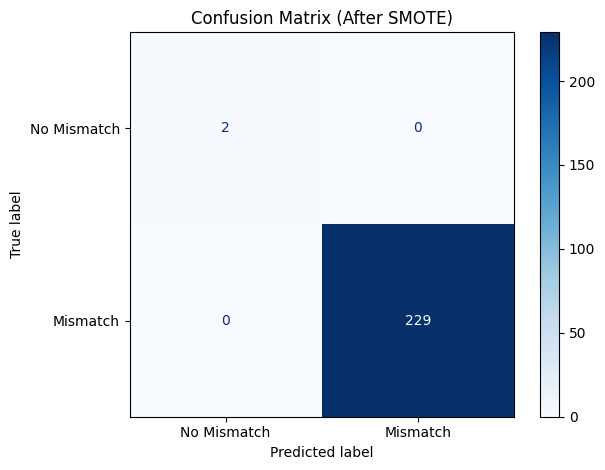

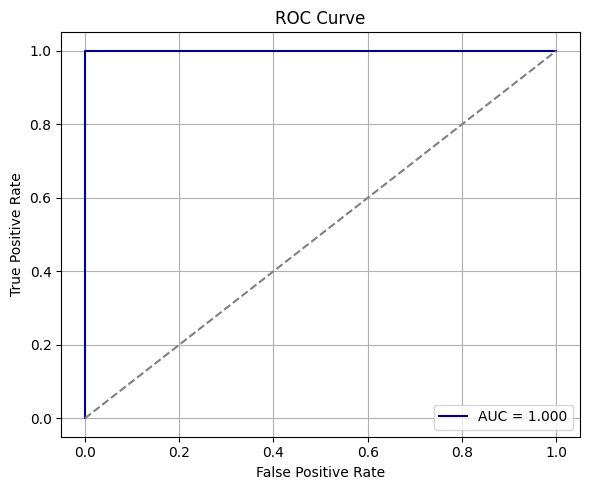

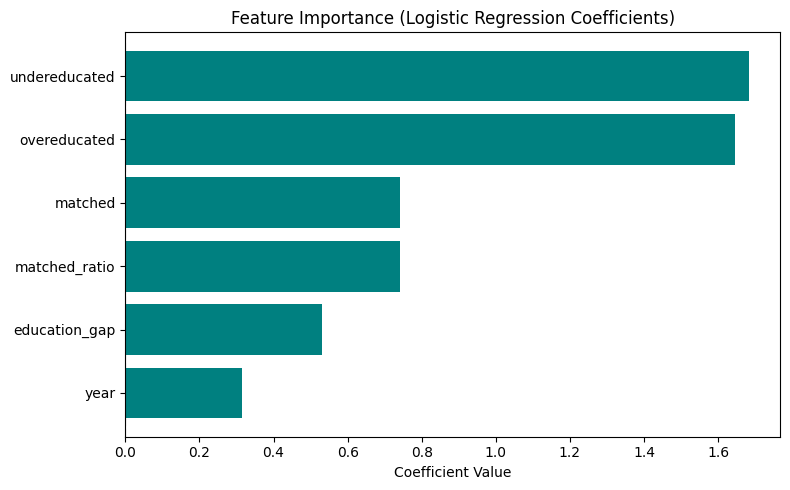

Cross-validated F1 Macro Scores: [1.         1.         1.         0.87279736 1.        ]
Average F1 Macro Score: 0.9745594713656388


In [ ]:
# ---------------------------------------------
# Logistic Regression with Feature Engineering, SMOTE, and Shared Test Split
# ---------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, roc_auc_score
)
from imblearn.over_sampling import SMOTE

# --------------------------
# Step 1: Prepare the Data
# --------------------------
df = merged_df.copy()

# Feature Engineering
df['matched_ratio'] = df['matched'] / df['total'].replace(0, pd.NA)
df['education_gap'] = df['overeducated'] - df['undereducated']
df['skills_mismatch'] = ((df['overeducated'] > 0) | (df['undereducated'] > 0)).astype(int)

# Select Features and Target
features = ['matched', 'overeducated', 'undereducated', 'year', 'matched_ratio', 'education_gap']
target = 'skills_mismatch'

# Drop Missing Values
df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

# --------------------------
# Step 2: Scale Features
# --------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------
# Step 3: Train/Test Split (before SMOTE for fairness)
# --------------------------
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------------
# Step 4: Apply SMOTE on training set only
# --------------------------
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_base, y_train_base)
X_test = X_test_base
y_test = y_test_base

print("Original class distribution:\n", y.value_counts())
print("\nResampled class distribution:\n", pd.Series(y_train).value_counts())

# --------------------------
# Step 5: Train Logistic Regression
# --------------------------
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# --------------------------
# Step 6: Evaluate
# --------------------------
y_pred_log = model.predict(X_test)
y_proba_log = model.predict_proba(X_test)[:, 1]  # For ROC/AUC

print("\nModel Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Mismatch", "Mismatch"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (After SMOTE)")
plt.tight_layout()
plt.show()

# --------------------------
# Step 7: ROC Curve + AUC
# --------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba_log)
auc_score = roc_auc_score(y_test, y_proba_log)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------
# Step 8: Feature Importance
# --------------------------
coefficients = model.coef_[0]
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
importance_df['abs_coef'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='abs_coef', ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Coefficient'], color='teal')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

# --------------------------
# Step 9: Cross-Validation (on full original data)
# --------------------------
cv_scores = cross_val_score(
    LogisticRegression(class_weight='balanced', random_state=42),
    X_scaled, y,
    cv=5,
    scoring='f1_macro'
)

print("Cross-validated F1 Macro Scores:", cv_scores)
print("Average F1 Macro Score:", cv_scores.mean())

-- This enhanced logistic regression pipeline builds upon the basic model by incorporating feature engineering, handling class imbalance with SMOTE, and evaluating model performance more rigorously. The process begins by copying the original merged dataset and engineering two new features: matched_ratio (matched ÷ total) to represent the proportion of well-matched individuals, and education_gap (overeducated − undereducated) to capture directional imbalance. A binary target variable, skills_mismatch, is created to flag any form of mismatch. The model uses six predictors: the original four (matched, overeducated, undereducated, year) and the two new engineered features. All missing values are dropped, and features are standardized using StandardScaler for optimal logistic regression performance.

To ensure fair model training, the dataset is split into training and test sets before applying SMOTE, which is then used only on the training data to synthetically balance the class distribution. After confirming improved balance, a logistic regression model is fitted, and its predictions on the untouched test set are evaluated using accuracy, a detailed classification report, and a confusion matrix. ROC-AUC is also computed and visualized, offering insight into the model’s discrimination ability between matched and mismatched cases. Feature importance is analyzed using the model’s coefficients, visualized in a horizontal bar chart to identify which predictors most strongly influence the classification. Finally, 5-fold cross-validation is performed on the full dataset using F1 macro scoring, providing a robust measure of model generalizability. Altogether, this workflow presents a more informed, balanced, and interpretable approach to predicting skills mismatch in the labour market. --

## K-Means Clustering

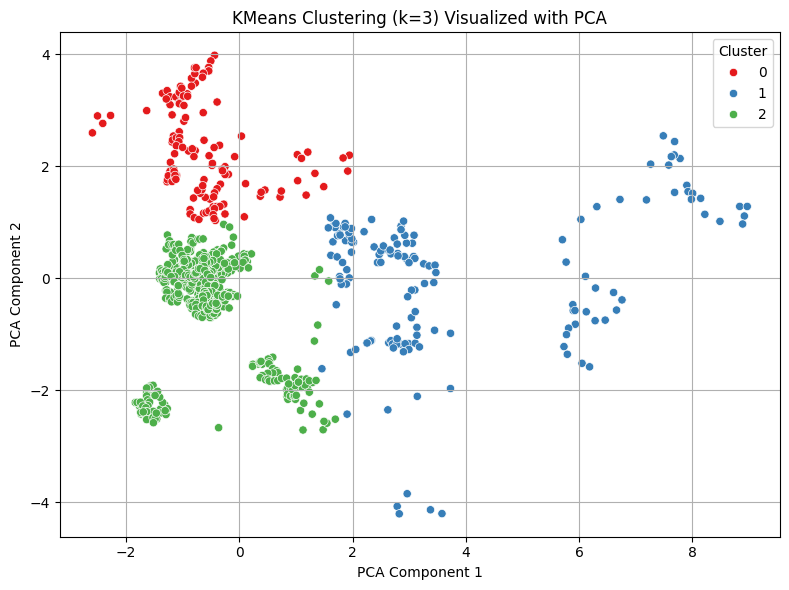

Silhouette Score for k=3: 0.555


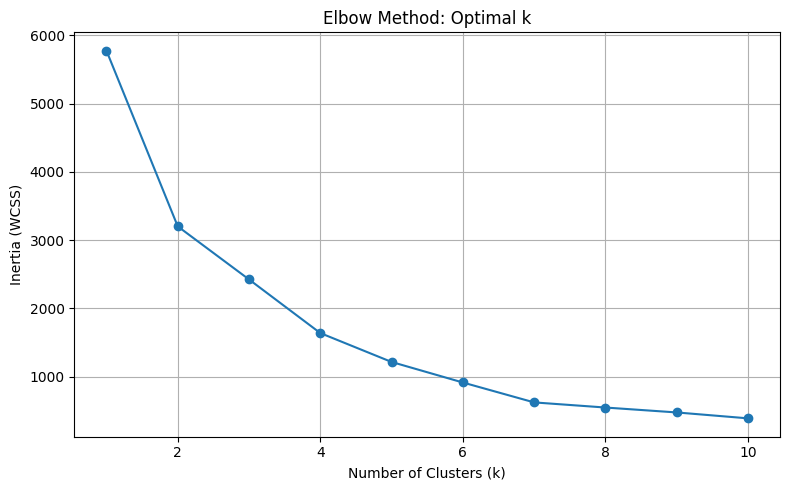

In [ ]:
# ---------------------------------------------
# KMeans Clustering with Evaluation & Cross-Validation
# ---------------------------------------------

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the data
df = merged_df.copy()

# Add engineered features
df['matched_ratio'] = df['matched'] / df['total'].replace(0, pd.NA)
df['education_gap'] = df['overeducated'] - df['undereducated']

# Drop rows with missing values
features = ['matched', 'overeducated', 'undereducated', 'matched_ratio', 'education_gap']
df_cluster = df[features].dropna()

# Step 2: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Step 4: Visualize with PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='cluster', palette='Set1')
plt.title("KMeans Clustering (k=3) Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Evaluation using Silhouette Score
sil_score = silhouette_score(X_scaled, df_cluster['cluster'])
print(f"Silhouette Score for k=3: {sil_score:.3f}")

# Step 6: Elbow Method for Optimal k
inertia = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method: Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.grid(True)
plt.tight_layout()
plt.show()


-- This code block applies KMeans clustering to uncover hidden patterns in the skills mismatch data by grouping observations based on similarity in engineered and raw features. The process begins with the preparation of the dataset, including the addition of two meaningful features: matched_ratio (indicating the proportion of well-matched individuals) and education_gap (capturing the directional imbalance between over- and undereducation). After removing rows with missing values, the relevant features are scaled using StandardScaler to ensure that each feature contributes equally to the clustering process. A KMeans algorithm is then applied with k=3 clusters, and the resulting group labels are assigned to each observation.

To visualize the high-dimensional clusters, Principal Component Analysis (PCA) is used to reduce the data to two dimensions. A scatterplot is created to show the distribution of clusters in this reduced space, helping to interpret the structure and separation between groups. To assess the clustering quality, the silhouette score is calculated, which quantifies how well-separated and internally coherent the clusters are (with higher scores indicating better performance). Finally, the elbow method is implemented by plotting inertia (within-cluster sum of squares) for k values ranging from 1 to 10. This plot helps identify the optimal number of clusters by locating the "elbow point"—the value of k where adding more clusters yields diminishing returns. Altogether, this clustering workflow offers valuable insights into subgroups of labour market participants who share similar mismatch characteristics, supporting segmentation analysis and targeted policy or program design. --

### Performance Improvement Strategies

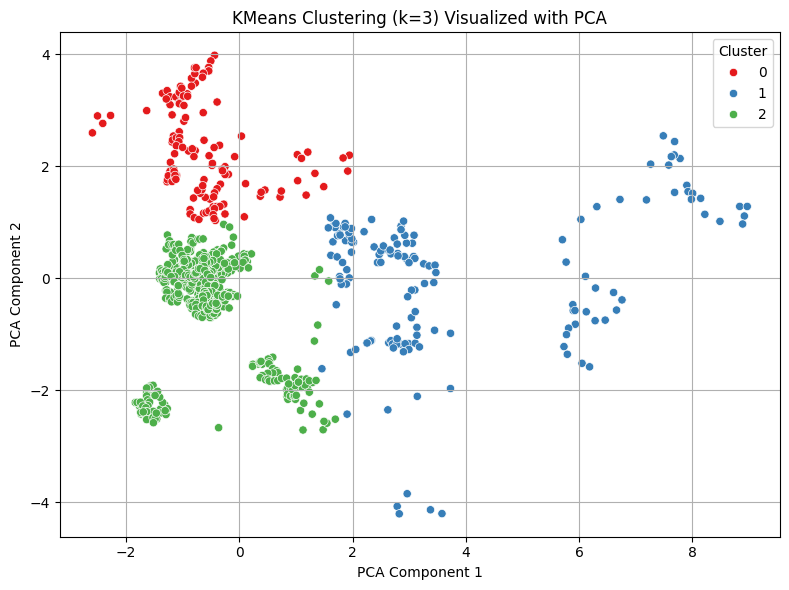

Silhouette Score for k=3: 0.555


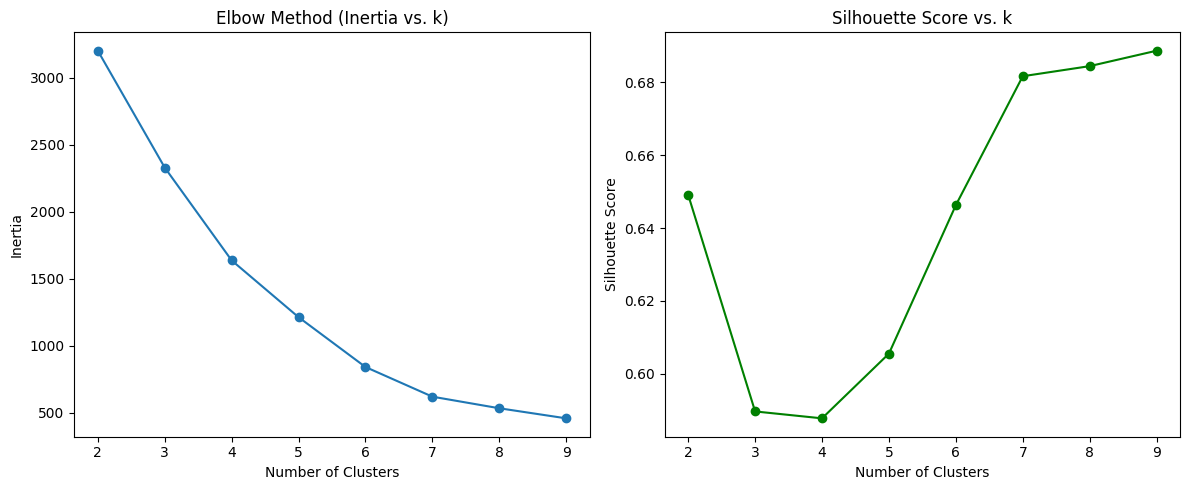

Adjusted Rand Index (vs. skills_mismatch): 0.032

Stratified K-Fold Silhouette Scores: [np.float64(0.5399598652377614), np.float64(0.5707528787165851), np.float64(0.5606152163003927), np.float64(0.5575049050398323), np.float64(0.5568239656596633)]
Average Silhouette Score: 0.5571313661908469


In [ ]:
# ---------------------------------------------
# KMeans Clustering with All Enhancements and Evaluation
# ---------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import StratifiedKFold

# Step 1: Load and Prepare Data
df = merged_df.copy()

# Step 2: Feature Engineering
df['matched_ratio'] = df['matched'] / df['total'].replace(0, pd.NA)
df['education_gap'] = df['overeducated'] - df['undereducated']
df['skills_mismatch'] = ((df['overeducated'] > 0) | (df['undereducated'] > 0)).astype(int)

features = ['matched', 'overeducated', 'undereducated', 'matched_ratio', 'education_gap']
df_cluster = df[features + ['skills_mismatch']].dropna()

# Step 3: Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])
y_true = df_cluster['skills_mismatch'].values

# Step 4: KMeans Clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Step 5: PCA for 2D Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='cluster', palette='Set1')
plt.title("KMeans Clustering (k=3) Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Silhouette Score Evaluation
sil_score = silhouette_score(X_scaled, df_cluster['cluster'])
print(f"Silhouette Score for k=3: {sil_score:.3f}")

# Step 7: Elbow Method and Silhouette Score for Optimal k
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, km.labels_))

# Plot Elbow and Silhouette
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Elbow plot
axes[0].plot(K, inertia, marker='o')
axes[0].set_title("Elbow Method (Inertia vs. k)")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Inertia")

# Silhouette plot
axes[1].plot(K, silhouette_scores, marker='o', color='green')
axes[1].set_title("Silhouette Score vs. k")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

# Step 8: Adjusted Rand Index as external evaluation
ari = adjusted_rand_score(y_true, df_cluster['cluster'])
print(f"Adjusted Rand Index (vs. skills_mismatch): {ari:.3f}")

# Step 9: Pseudo-Cross-Validation using Stratified K-Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []

for train_idx, test_idx in skf.split(X_scaled, y_true):
    X_fold, y_fold = X_scaled[train_idx], y_true[train_idx]
    km = KMeans(n_clusters=3, random_state=42, n_init='auto')
    labels = km.fit_predict(X_fold)
    score = silhouette_score(X_fold, labels)
    fold_scores.append(score)

print("\nStratified K-Fold Silhouette Scores:", fold_scores)
print("Average Silhouette Score:", sum(fold_scores) / len(fold_scores))


-- This advanced KMeans clustering pipeline performs unsupervised segmentation of skills mismatch patterns, incorporating feature engineering, evaluation metrics, and pseudo-cross-validation for robust analysis. The process begins with feature engineering from the merged dataset, adding two informative metrics: matched_ratio (proportion of well-matched individuals) and education_gap (difference between overeducated and undereducated individuals). A binary target variable skills_mismatch is also created for external validation purposes, although it is not used during clustering. After filtering out missing values, the selected features are standardized using StandardScaler to ensure all variables contribute equally to the clustering process.

A KMeans model with k=3 is trained on the scaled data, and the resulting cluster assignments are visualized using Principal Component Analysis (PCA) in two dimensions. The separation of clusters is assessed using the silhouette score, a metric that evaluates how distinct and cohesive the clusters are. To determine the optimal number of clusters, both the Elbow Method (based on inertia) and Silhouette Analysis are plotted across values of k from 2 to 9. Additionally, the Adjusted Rand Index (ARI) is calculated to compare the clustering outcome with the known skills_mismatch labels—measuring the similarity between the unsupervised clusters and the actual mismatch classification. Lastly, a pseudo-cross-validation strategy using Stratified K-Folds is applied to simulate repeated clustering across data splits, with average silhouette scores providing an estimate of clustering stability. This comprehensive workflow not only identifies natural groupings within the dataset but also evaluates their quality and relevance to real-world labour mismatch patterns. --

# Ensemble Model

## Random Forest Classifier

Random Forest Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       229

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231



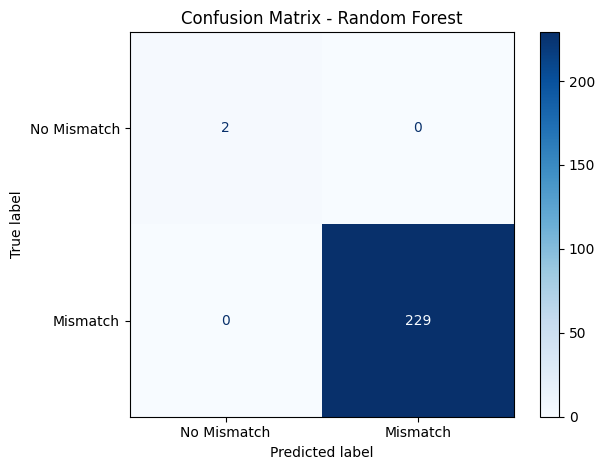

<ipython-input-36-717cd5b89179>:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




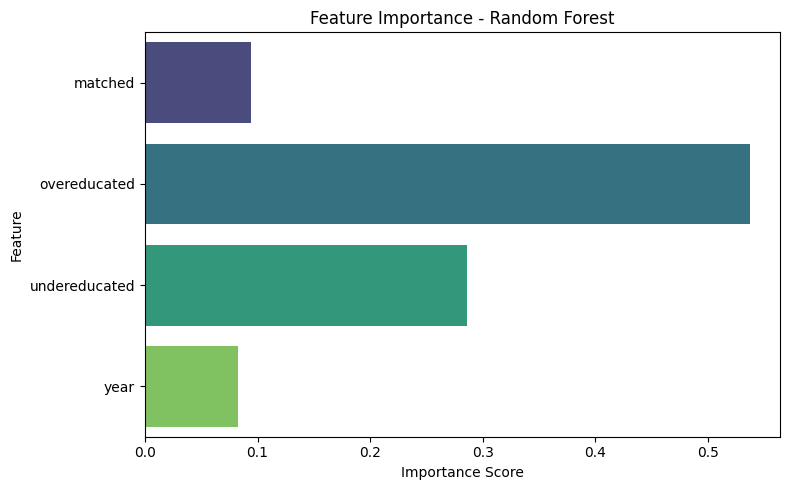

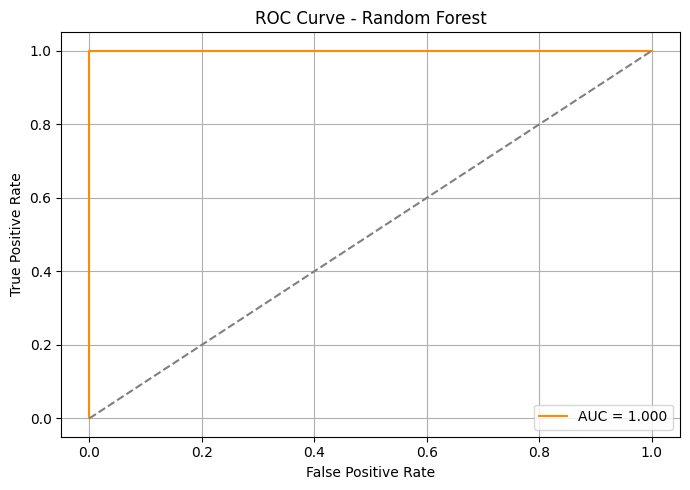

In [ ]:
# --------------------------------------------
# Random Forest Classifier (No Enhancements, Consistent Split)
# --------------------------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Train Random Forest model on same split
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict using consistent test set
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Print evaluation results
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Mismatch", "Mismatch"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

# Feature Importance
importances = rf_model.feature_importances_
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=X.columns, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ROC Curve + AUC
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
auc_score = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


-- This block implements a Random Forest classifier to predict skills mismatch using the same train-test split previously applied in the logistic regression model (after SMOTE balancing). Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of their predictions for classification tasks. The model is trained on the preprocessed and scaled features (X_train and y_train) and evaluated on the consistent test set (X_test). Performance metrics such as accuracy and a detailed classification report (including precision, recall, and F1-score) are printed to assess prediction quality. A confusion matrix is visualized to better understand the model's classification behavior, particularly in distinguishing between mismatched and well-matched cases. Additionally, feature importance scores are computed and displayed using a horizontal bar chart, offering insight into which features contribute most significantly to the model's decision-making. To further evaluate model performance, the ROC curve is plotted along with the AUC score, providing a visual and numerical measure of the model's ability to distinguish between classes across different probability thresholds. Overall, this Random Forest implementation serves as a powerful, interpretable baseline for classifying skills mismatch, offering both robust accuracy and rich insights into feature relevance. --

### Performance Improvement Strategies

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score: 1.0
Tuned Random Forest Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       229
           1       1.00      1.00      1.00       229

    accuracy                           1.00       458
   macro avg       1.00      1.00      1.00       458
weighted avg       1.00      1.00      1.00       458



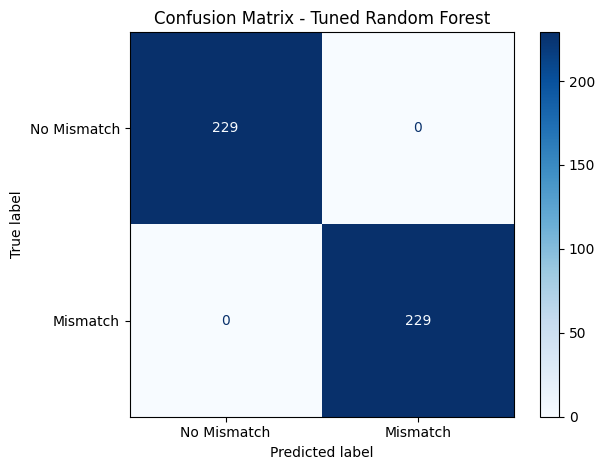

<ipython-input-26-88976ee3e697>:86: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




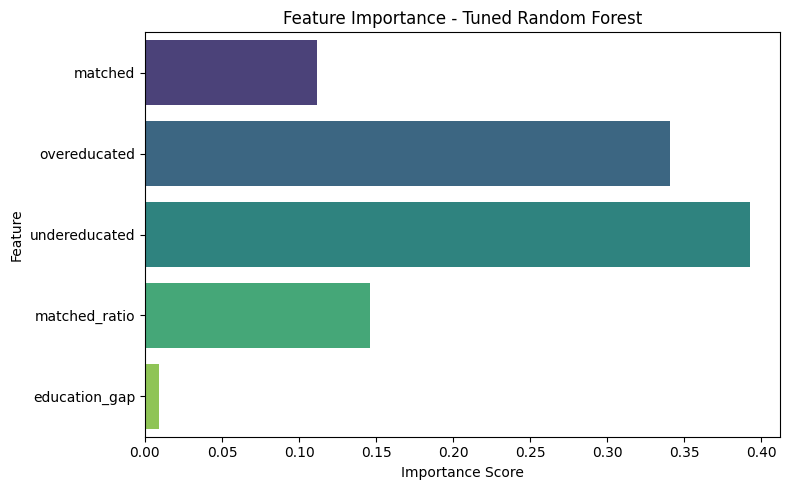

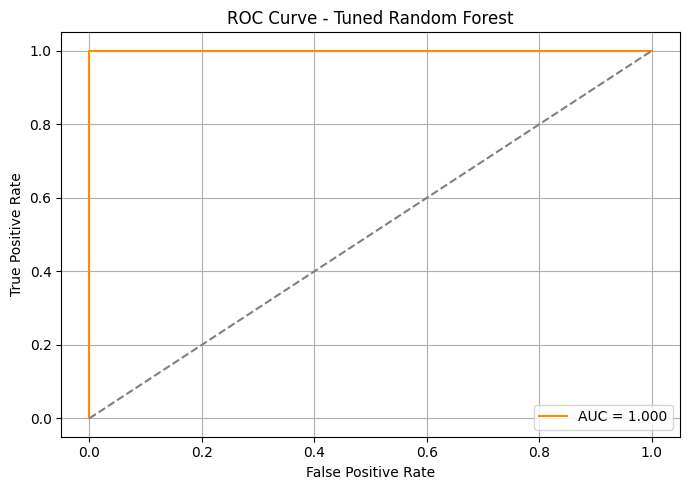

Cross-validated F1 Macro Scores: [1.         1.         1.         0.98905719 1.        ]
Average F1 Macro Score: 0.9978114389429777


In [ ]:
# --------------------------------------------
# Random Forest Classifier (Enhanced with SMOTE, Feature Engineering, Tuning, CV)
# --------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)
from imblearn.over_sampling import SMOTE

# Step 1: Prepare Data from merged_df
df = merged_df.copy()
df['matched_ratio'] = df['matched'] / df['total'].replace(0, pd.NA)
df['education_gap'] = df['overeducated'] - df['undereducated']
df['skills_mismatch'] = ((df['overeducated'] > 0) | (df['undereducated'] > 0)).astype(int)

features = ['matched', 'overeducated', 'undereducated', 'matched_ratio', 'education_gap']
target = 'skills_mismatch'

# Drop missing values
df_rf = df[features + [target]].dropna()
X = df_rf[features]
y = df_rf[target]

# Step 2: Scale the features and apply SMOTE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Step 3: Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_resampled, y_resampled)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 5: Train Best Model
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Step 6: Predict and Evaluate
y_pred_rf = best_rf_model.predict(X_test)
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]
print("Tuned Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Mismatch", "Mismatch"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.tight_layout()
plt.show()

# Step 7: Feature Importance
importances = best_rf_model.feature_importances_
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette="viridis")
plt.title("Feature Importance - Tuned Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Step 8: ROC Curve + AUC Score
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
auc_score = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - Tuned Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Cross-Validation Evaluation
cv_scores = cross_val_score(
    best_rf_model, X_resampled, y_resampled, cv=5, scoring='f1_macro'
)

print("Cross-validated F1 Macro Scores:", cv_scores)
print("Average F1 Macro Score:", cv_scores.mean())


-- This code block presents a fully optimized Random Forest classifier to predict skills mismatch, incorporating advanced enhancements such as feature engineering, SMOTE for class balancing, hyperparameter tuning, and cross-validation. The dataset is first enriched with two engineered features—matched_ratio and education_gap—that offer deeper insights into the educational alignment between individuals and their occupations. The binary target variable skills_mismatch flags whether a mismatch exists (either overeducated or undereducated). After removing missing values, the selected features are standardized to ensure uniform scale, followed by the application of SMOTE to oversample the minority class and address potential imbalances in mismatch classification.

The model undergoes hyperparameter tuning using GridSearchCV, which explores combinations of parameters such as tree depth, number of estimators, and feature-splitting strategies, evaluated through stratified 5-fold cross-validation. Once the best model configuration is identified, the resampled dataset is split into training and test sets for final evaluation. The model is trained and assessed using accuracy, a classification report (precision, recall, F1-score), and a confusion matrix for clarity on prediction accuracy across both classes. Feature importance scores are visualized to reveal which variables have the most influence on predicting mismatch. An ROC curve with AUC score is generated to evaluate the model’s ability to distinguish between classes across different thresholds. Finally, a cross-validated F1 macro score provides an additional performance benchmark, ensuring model reliability across various data splits. This refined pipeline delivers a robust, interpretable, and well-generalized model for identifying patterns of skills mismatch in the labour market. --

## XGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[11:30:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBoost Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       229

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231



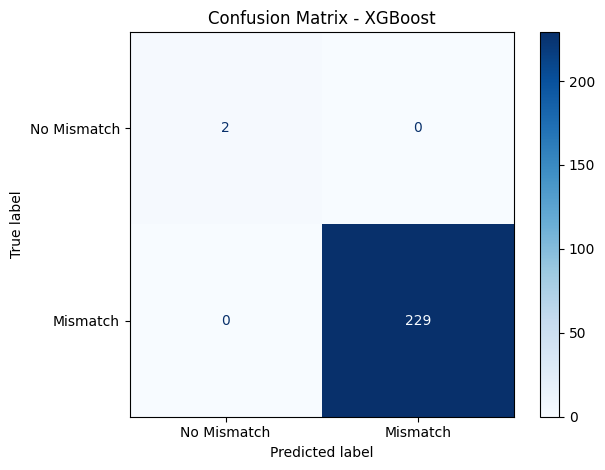

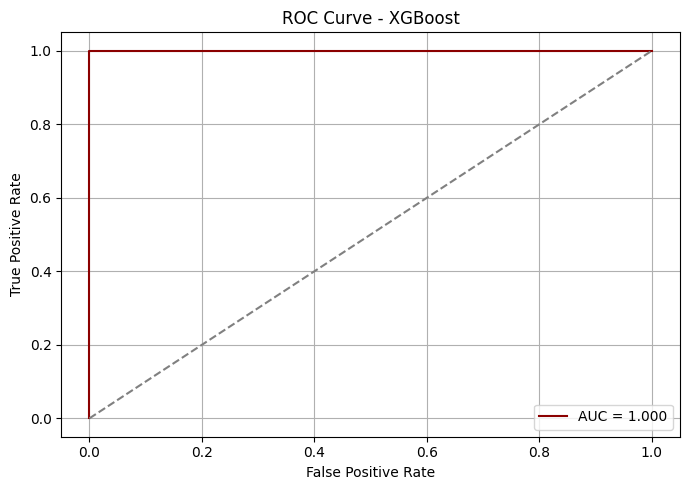

<ipython-input-27-fd8fa6e62a17>:77: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




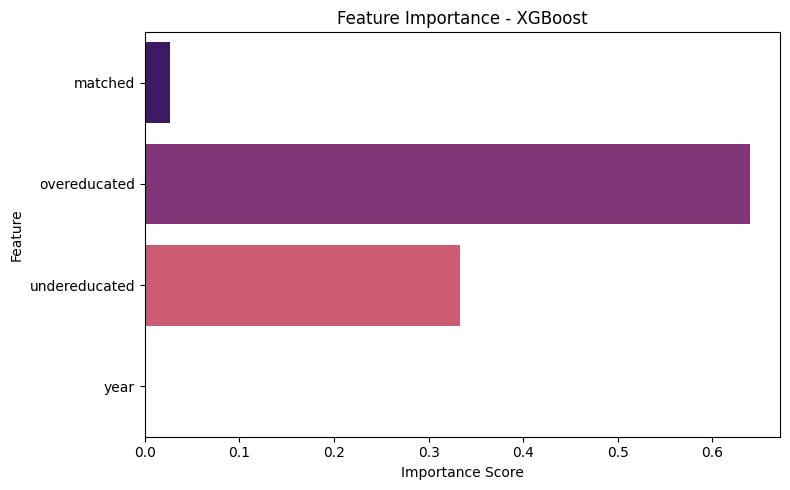

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[11:30:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[11:30:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[11:30:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[11:30:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Cross-validated F1 Macro Scores: [0.83224401 1.         1.         0.76718404 1.        ]
Average F1 Macro Score: 0.919885608838263


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[11:30:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




In [ ]:
# --------------------------------------------
# XGBoost Classifier (No Enhancements)
# --------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)

# Step 1: Prepare Data
df = merged_df.copy()
df['skills_mismatch'] = ((df['overeducated'] > 0) | (df['undereducated'] > 0)).astype(int)

features = ['matched', 'overeducated', 'undereducated', 'year']
target = 'skills_mismatch'

# Drop missing values
df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

# Step 2: Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Step 4: Train XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Step 5: Evaluation
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

conf_matrix = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Mismatch", "Mismatch"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.tight_layout()
plt.show()

# Step 6: ROC Curve + AUC
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
auc_score = roc_auc_score(y_test, y_proba_xgb)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", color='darkred')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 7: Feature Importance
importances = xgb_model.feature_importances_
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette="magma")
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Step 8: Cross-Validation Evaluation
cv_scores_final = cross_val_score(xgb_model, X_scaled, y, cv=5, scoring='f1_macro')
print("Cross-validated F1 Macro Scores:", cv_scores_final)
print("Average F1 Macro Score:", cv_scores_final.mean())

-- This code block applies a basic XGBoost classifier to predict skills mismatch based on four key features: matched, overeducated, undereducated, and year. The process begins with preparing the data from the merged_df dataset by creating a binary target variable, skills_mismatch, which identifies whether an individual is mismatched in their role. After filtering out rows with missing values, the features are standardized using StandardScaler to ensure uniform scaling across predictors. The dataset is then split into training and testing sets using stratified sampling to preserve class distribution.

The XGBoost model is trained with default settings (except for disabling label encoding and setting the evaluation metric to log loss), and its performance is evaluated on the test set. Accuracy and a detailed classification report provide insights into the model's predictive quality across both matched and mismatched classes. A confusion matrix is plotted for intuitive interpretation of prediction errors, while the ROC curve and AUC score measure the model’s ability to discriminate between classes across thresholds. Feature importances are also visualized using a bar chart, helping to identify which predictors most influence the model’s decisions. Finally, a 5-fold cross-validation using F1 macro scoring offers an estimate of the model's generalization ability. Overall, this implementation demonstrates the effectiveness of XGBoost as a powerful and interpretable baseline model for identifying skills mismatch without additional tuning or enhancements. --

### Performance Improvement Strategies

Class Distribution: Counter({1: 1143, 0: 12})
Calculated scale_pos_weight: 0.010498687664041995


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:07:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:07:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:07:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:07:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Initial Cross-Validation Accuracy Scores: [1.       1.       1.       0.995671 1.      ]
Mean CV Accuracy: 0.9991341991341992
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:07:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:07:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 0.010498687664041995, 'subsample': 0.8}
Best CV Score: 0.9965367965367966

Top Grid Search Results:


,params,mean_test_score,std_test_score
0,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.996537,0.004242
2,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.996537,0.004242
6,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.996537,0.004242
4,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.996537,0.004242
22,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.996537,0.004242


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:07:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Final Accuracy: 0.9826839826839827
Precision: 1.0
Recall: 0.982532751091703
F1 Score: 0.9911894273127754
Balanced Accuracy: 0.9912663755458515

Classification Report:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       1.00      0.98      0.99       229

    accuracy                           0.98       231
   macro avg       0.67      0.99      0.75       231
weighted avg       0.99      0.98      0.99       231



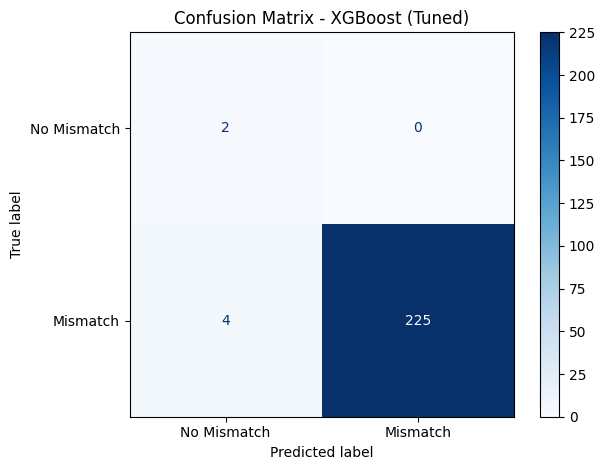

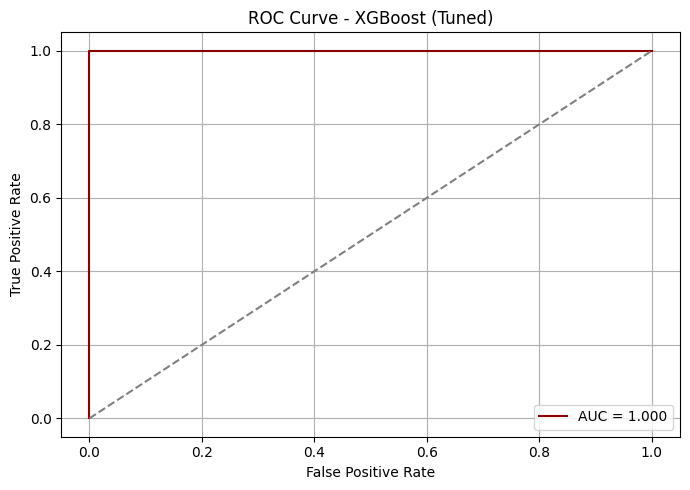

<ipython-input-10-bf4eac35a16f>:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette="magma")


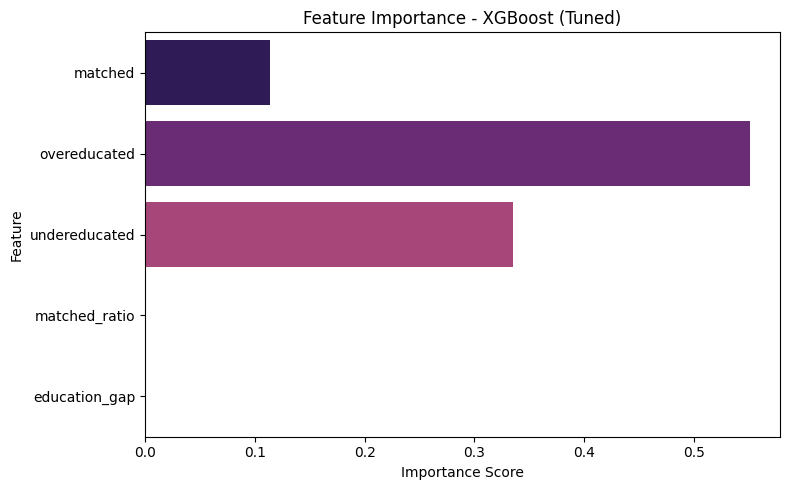

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:08:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:08:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:08:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:08:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:08:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-validated F1 Macro Scores: [1.         1.         1.         0.76718404 1.        ]
Average F1 Macro Score: 0.9534368070953437

Generating SHAP Summary Plot...


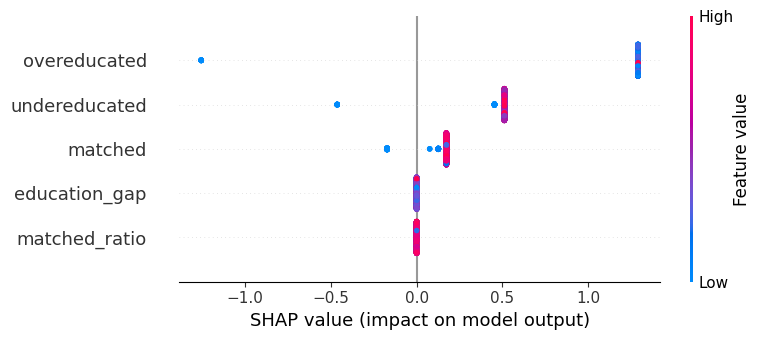

Model saved as 'xgb_skills_mismatch_model.pkl'


In [ ]:
# --------------------------------------------
# XGBoost Classifier (Enhanced with Feature Engineering, Tuning, CV, SHAP)
# --------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

from collections import Counter
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score
)

# Step 1: Prepare Data
df = merged_df.copy()
df['matched_ratio'] = df['matched'] / df['total'].replace(0, pd.NA)
df['education_gap'] = df['overeducated'] - df['undereducated']
df['skills_mismatch'] = ((df['overeducated'] > 0) | (df['undereducated'] > 0)).astype(int)

features = ['matched', 'overeducated', 'undereducated', 'matched_ratio', 'education_gap']
target = 'skills_mismatch'

df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

# Step 2: Handle Class Imbalance
counter = Counter(y)
scale_pos_weight = counter[0] / counter[1]
print("Class Distribution:", counter)
print("Calculated scale_pos_weight:", scale_pos_weight)

# Step 3: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Initial CV Before Tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cv_scores = cross_val_score(xgb, X_scaled, y, cv=cv, scoring='accuracy')
print("Initial Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Step 5: Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight]
}

grid_search = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_scaled, y)
print("\nBest Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Step 6: Grid Search Results Summary
cv_results = pd.DataFrame(grid_search.cv_results_)
print("\nTop Grid Search Results:")
display(cv_results.sort_values(by="mean_test_score", ascending=False)[[
    'params', 'mean_test_score', 'std_test_score'
]].head())

# Step 7: Final Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Step 8: Train Best Model
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Step 9: Evaluation
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print("\nFinal Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Mismatch", "Mismatch"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost (Tuned)")
plt.tight_layout()
plt.show()

# ROC Curve + AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", color='darkred')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - XGBoost (Tuned)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance
importances = best_xgb.feature_importances_
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette="magma")
plt.title("Feature Importance - XGBoost (Tuned)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Final Cross-Validation (F1 Macro)
cv_scores_final = cross_val_score(best_xgb, X_scaled, y, cv=5, scoring='f1_macro')
print("Cross-validated F1 Macro Scores:", cv_scores_final)
print("Average F1 Macro Score:", cv_scores_final.mean())

# Step 10: SHAP Analysis
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_scaled)

print("\nGenerating SHAP Summary Plot...")
shap.summary_plot(shap_values, features=X, feature_names=features)

# Step 11: Save Model
joblib.dump(best_xgb, "xgb_skills_mismatch_model.pkl")
print("Model saved as 'xgb_skills_mismatch_model.pkl'")


-- This advanced XGBoost classifier is designed to predict skills mismatch with a robust, interpretable, and well-validated approach. The pipeline begins by preparing the dataset with feature engineering, introducing two insightful metrics: matched_ratio (the proportion of workers properly matched to their roles) and education_gap (the net difference between over- and undereducation). A binary target variable, skills_mismatch, is constructed to identify instances of educational misalignment. After dropping missing values, the features are scaled using StandardScaler to standardize input data, ensuring numerical stability and optimal model performance.

To address class imbalance, the script calculates scale_pos_weight, allowing the model to better handle skewed class distributions during training. The model undergoes initial cross-validation to establish baseline performance, followed by hyperparameter tuning via GridSearchCV, which tests combinations of parameters such as learning rate, max depth, and subsampling ratio across stratified folds. The best-performing model is selected based on accuracy and trained on the stratified training set.

Evaluation metrics include accuracy, precision, recall, F1-score, and balanced accuracy, along with a confusion matrix, ROC curve, and AUC score for a comprehensive view of performance. Feature importance is visualized to identify the strongest predictors, while SHAP (SHapley Additive exPlanations) is employed to offer interpretable, model-agnostic insights into how each feature contributes to individual predictions. The pipeline concludes with a 5-fold cross-validation using the F1 macro score and saves the best-performing model as a .pkl file for future deployment. This complete workflow ensures both strong predictive accuracy and deep interpretability for detecting skills mismatch in the labour market. --

# Model Performance Comparison

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:24:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


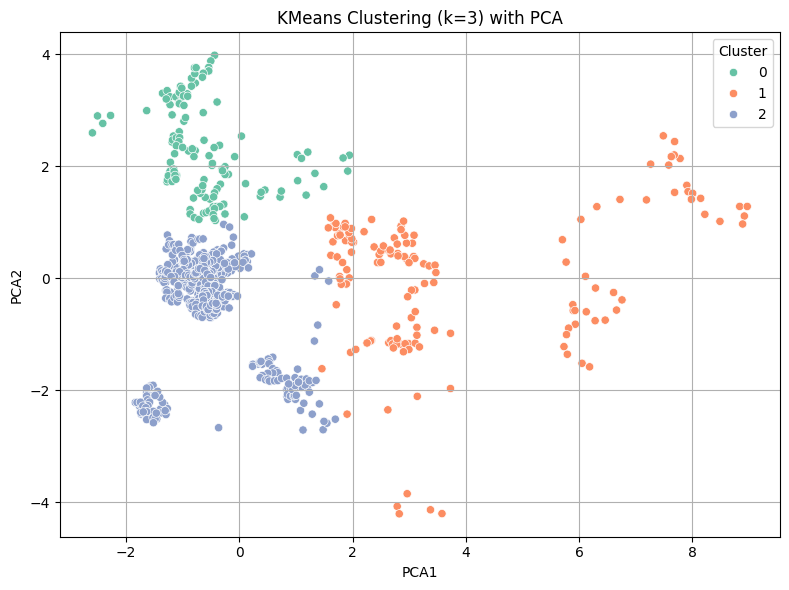


Model Performance Comparison:
                     Accuracy  Precision  Recall  F1-score  AUC  Silhouette
Model                                                                      
Logistic Regression       1.0        1.0     1.0       1.0  1.0         NaN
Random Forest             1.0        1.0     1.0       1.0  1.0         NaN
XGBoost                   1.0        1.0     1.0       1.0  1.0         NaN
KMeans Clustering         NaN        NaN     NaN       NaN  NaN    0.554754


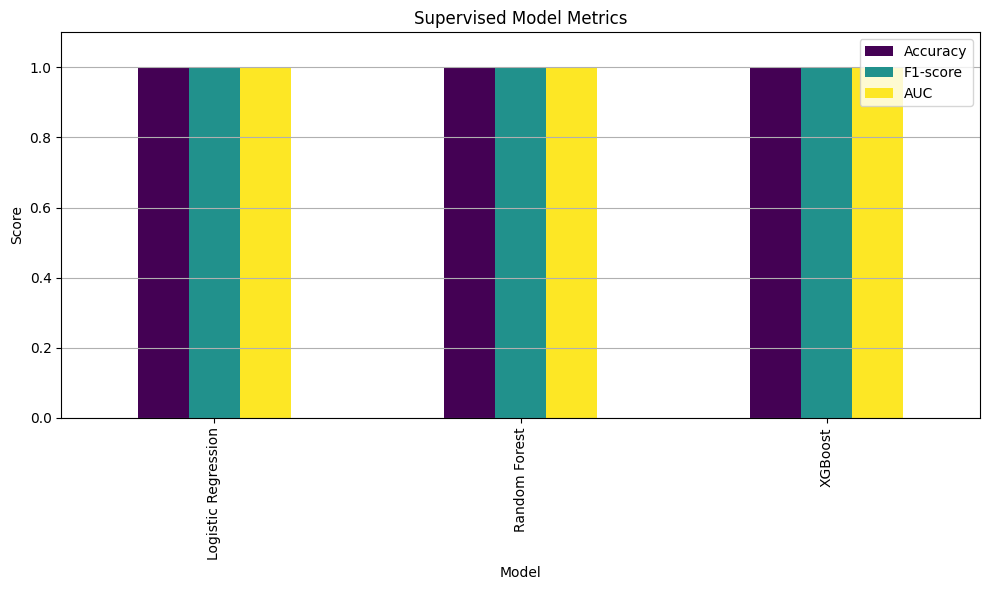

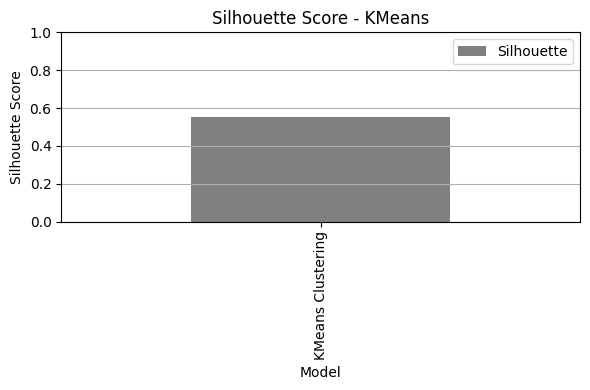

In [ ]:
# ----------------------------------------------------------------------------
# Unified ML Pipeline: Logistic, RF, XGBoost, KMeans without Enhancements
# ----------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, silhouette_score
)

# ----------------------------------
# Step 1: Data Preparation
# ----------------------------------
df = merged_df.copy()

# Feature Engineering
df['skills_mismatch'] = ((df['overeducated'] > 0) | (df['undereducated'] > 0)).astype(int)
df['matched_ratio'] = df['matched'] / df['total'].replace(0, np.nan)
df['education_gap'] = df['overeducated'] - df['undereducated']

# Features and Target
features = ['matched', 'overeducated', 'undereducated', 'matched_ratio', 'education_gap']
target = 'skills_mismatch'

df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Consistent Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------------------
# Step 2: Train Models
# ----------------------------------

# Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# ----------------------------------
# Step 3: KMeans Clustering (Unsupervised)
# ----------------------------------
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)
silhouette = silhouette_score(X_scaled, kmeans_labels)

# PCA for Visualizing KMeans
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_plot = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])
df_plot['Cluster'] = kmeans_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_plot, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("KMeans Clustering (k=3) with PCA")
plt.tight_layout()
plt.grid(True)
plt.show()

# ----------------------------------
# Step 4: Model Performance Comparison
# ----------------------------------

results = [
    {
        'Model': 'Logistic Regression',
        'Accuracy': accuracy_score(y_test, y_pred_log),
        'Precision': precision_score(y_test, y_pred_log),
        'Recall': recall_score(y_test, y_pred_log),
        'F1-score': f1_score(y_test, y_pred_log),
        'AUC': roc_auc_score(y_test, y_proba_log),
        'Silhouette': None
    },
    {
        'Model': 'Random Forest',
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision': precision_score(y_test, y_pred_rf),
        'Recall': recall_score(y_test, y_pred_rf),
        'F1-score': f1_score(y_test, y_pred_rf),
        'AUC': roc_auc_score(y_test, y_proba_rf),
        'Silhouette': None
    },
    {
        'Model': 'XGBoost',
        'Accuracy': accuracy_score(y_test, y_pred_xgb),
        'Precision': precision_score(y_test, y_pred_xgb),
        'Recall': recall_score(y_test, y_pred_xgb),
        'F1-score': f1_score(y_test, y_pred_xgb),
        'AUC': roc_auc_score(y_test, y_proba_xgb),
        'Silhouette': None
    },
    {
        'Model': 'KMeans Clustering',
        'Accuracy': None,
        'Precision': None,
        'Recall': None,
        'F1-score': None,
        'AUC': None,
        'Silhouette': silhouette
    }
]

comparison_df = pd.DataFrame(results).set_index("Model")
print("\nModel Performance Comparison:")
print(comparison_df)

# ----------------------------------
# Step 5: Visualization
# ----------------------------------

# Supervised model performance plot (Accuracy, F1, AUC)
supervised_metrics = comparison_df.dropna(subset=['Accuracy'])[['Accuracy', 'F1-score', 'AUC']]

supervised_metrics.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Supervised Model Metrics")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# KMeans Silhouette Score
if comparison_df['Silhouette'].notna().any():
    comparison_df[['Silhouette']].dropna().plot(
        kind='bar', figsize=(6, 4), color='gray', title="Silhouette Score - KMeans"
    )
    plt.ylabel("Silhouette Score")
    plt.ylim(0, 1.0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


-- This unified machine learning pipeline brings together three supervised models—Logistic Regression, Random Forest, and XGBoost—alongside an unsupervised KMeans clustering approach to analyze skills mismatch using the same consistent dataset and preprocessing steps. The dataset is first enriched with feature engineering, including a binary skills_mismatch target, matched_ratio, and education_gap. After removing missing values and standardizing the features, the data is split into training and testing sets to ensure fair model evaluation.

Each supervised model is trained on the same split: Logistic Regression provides a simple linear baseline, Random Forest adds non-linearity and feature bagging, while XGBoost offers a powerful boosting-based approach. For each, standard evaluation metrics such as accuracy, precision, recall, F1-score, and AUC are computed, allowing for side-by-side comparison of classification performance. Meanwhile, KMeans clustering is applied in an unsupervised fashion, with results visualized using PCA to project clusters into two dimensions, and evaluated using the silhouette score, which measures cohesion and separation among clusters.

Finally, the pipeline summarizes results in a comparison table and visualizes key metrics through bar charts, enabling a clear and concise comparison of all models. This consolidated view supports informed decision-making on which modeling approach is most effective for identifying and analyzing skills mismatch in the labour market, with interpretability and performance both taken into account. --

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[12:34:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[12:34:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




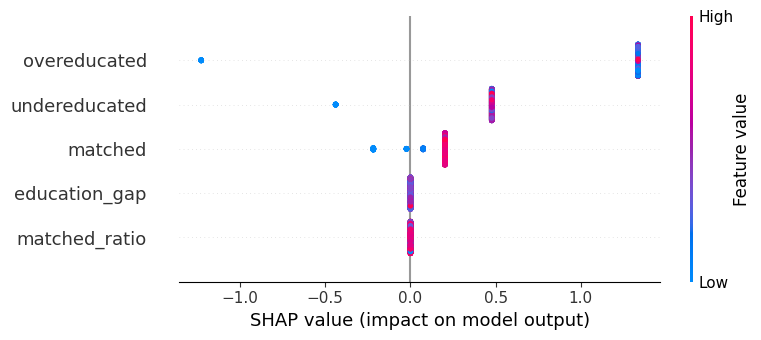


📊 Final Model Performance Comparison:
                     Accuracy  Precision    Recall  F1 Score  AUC  \
Model                                                               
Logistic Regression  1.000000        1.0  1.000000  1.000000  1.0   
Random Forest        1.000000        1.0  1.000000  1.000000  1.0   
XGBoost              0.982684        1.0  0.982533  0.991189  1.0   
KMeans Clustering         NaN        NaN       NaN       NaN  NaN   

                     Silhouette Score  Adjusted Rand Index  
Model                                                       
Logistic Regression               NaN                  NaN  
Random Forest                     NaN                  NaN  
XGBoost                           NaN                  NaN  
KMeans Clustering            0.554754             0.032466  


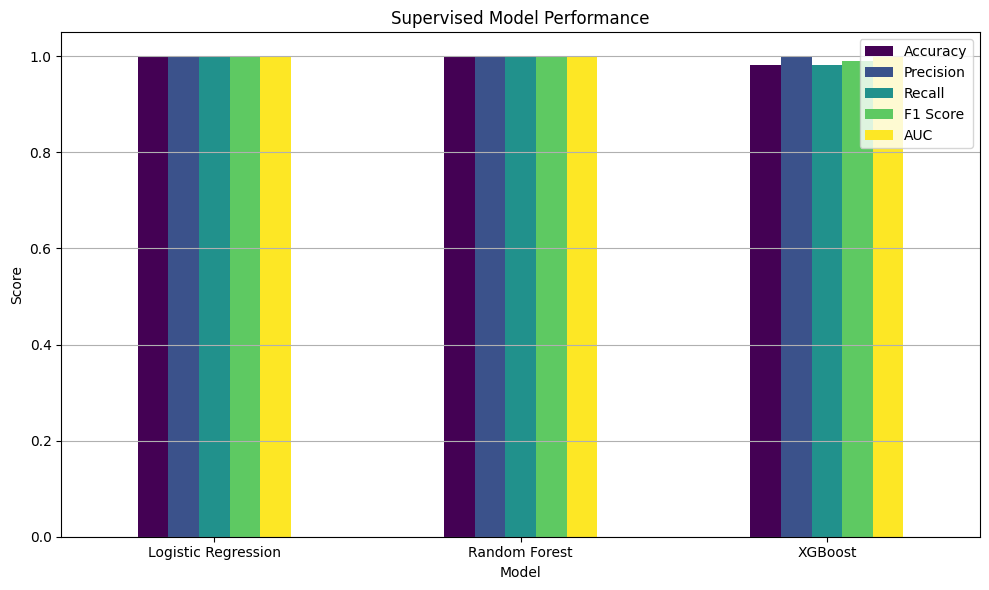

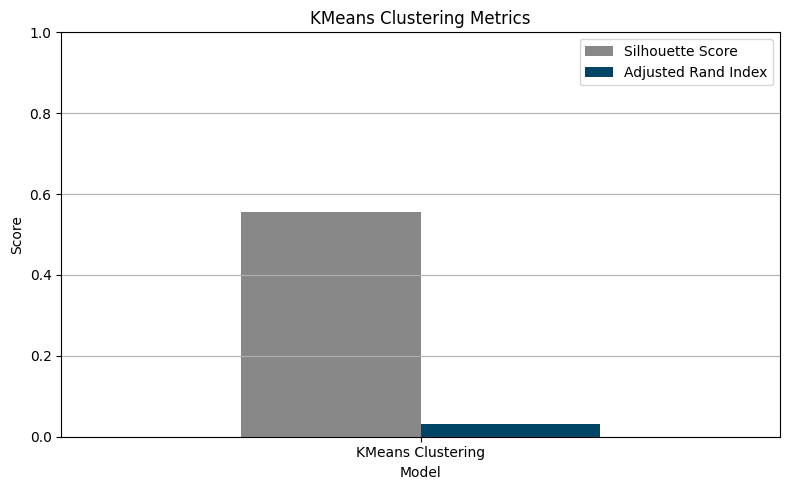

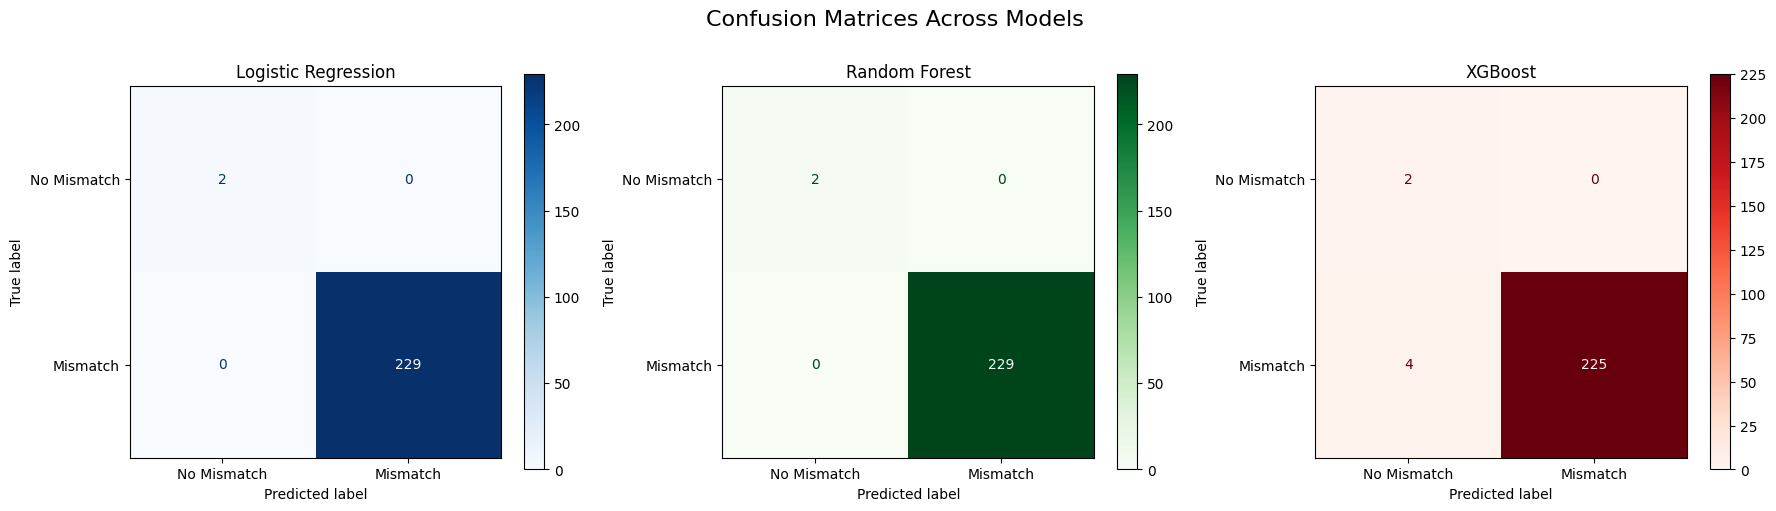

In [ ]:
# ----------------------------------------------------------------------------
# Unified ML Pipeline: Logistic, RF, XGBoost, KMeans with Enhancements
# ----------------------------------------------------------------------------

# -------------------------------
# 1. Feature Engineering & Setup
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, silhouette_score, adjusted_rand_score
)
from imblearn.over_sampling import SMOTE
import shap
import joblib

# Copy and engineer data
df = merged_df.copy()
df['matched_ratio'] = df['matched'] / df['total'].replace(0, pd.NA)
df['education_gap'] = df['overeducated'] - df['undereducated']
df['skills_mismatch'] = ((df['overeducated'] > 0) | (df['undereducated'] > 0)).astype(int)

features = ['matched', 'overeducated', 'undereducated', 'matched_ratio', 'education_gap']
target = 'skills_mismatch'

df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Shared train/test split
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to training only
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_base, y_train_base)
X_test = X_test_base
y_test = y_test_base

# -------------------------------
# 2. Logistic Regression
# -------------------------------
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

# -------------------------------
# 3. Random Forest (Tuned)
# -------------------------------
rf_grid = {
    'n_estimators': [100],
    'max_depth': [None, 5],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}
rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_search = GridSearchCV(rf, rf_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=0)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# -------------------------------
# 4. XGBoost (Tuned + SHAP)
# -------------------------------
scale_pos_weight = Counter(y)[0] / Counter(y)[1]
xgb_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.1],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight]
}
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_search = GridSearchCV(xgb, xgb_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=0)
xgb_search.fit(X_scaled, y)
best_xgb = xgb_search.best_estimator_

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
best_xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = best_xgb.predict(X_test_xgb)
y_proba_xgb = best_xgb.predict_proba(X_test_xgb)[:, 1]

# SHAP
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_scaled)
shap.summary_plot(shap_values, features=X, feature_names=features)

# -------------------------------
# 5. KMeans Clustering
# -------------------------------
df_cluster = df_model.copy()
X_kmeans = StandardScaler().fit_transform(df_cluster[features])
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_cluster['cluster'] = kmeans.fit_predict(X_kmeans)
df_cluster['PCA1'], df_cluster['PCA2'] = PCA(n_components=2).fit_transform(X_kmeans).T

sil_score = silhouette_score(X_kmeans, df_cluster['cluster'])
ari = adjusted_rand_score(df_cluster['skills_mismatch'], df_cluster['cluster'])

# -------------------------------
# 6. Model Comparison Table
# -------------------------------
comparison = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Accuracy": accuracy_score(y_test, y_pred_log),
        "Precision": precision_score(y_test, y_pred_log),
        "Recall": recall_score(y_test, y_pred_log),
        "F1 Score": f1_score(y_test, y_pred_log),
        "AUC": roc_auc_score(y_test, y_proba_log),
        "Silhouette Score": None,
        "Adjusted Rand Index": None
    },
    {
        "Model": "Random Forest",
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Precision": precision_score(y_test, y_pred_rf),
        "Recall": recall_score(y_test, y_pred_rf),
        "F1 Score": f1_score(y_test, y_pred_rf),
        "AUC": roc_auc_score(y_test, y_proba_rf),
        "Silhouette Score": None,
        "Adjusted Rand Index": None
    },
    {
        "Model": "XGBoost",
        "Accuracy": accuracy_score(y_test_xgb, y_pred_xgb),
        "Precision": precision_score(y_test_xgb, y_pred_xgb),
        "Recall": recall_score(y_test_xgb, y_pred_xgb),
        "F1 Score": f1_score(y_test_xgb, y_pred_xgb),
        "AUC": roc_auc_score(y_test_xgb, y_proba_xgb),
        "Silhouette Score": None,
        "Adjusted Rand Index": None
    },
    {
        "Model": "KMeans Clustering",
        "Accuracy": None,
        "Precision": None,
        "Recall": None,
        "F1 Score": None,
        "AUC": None,
        "Silhouette Score": sil_score,
        "Adjusted Rand Index": ari
    }
]).set_index("Model")

print("\n📊 Final Model Performance Comparison:")
print(comparison)

# -------------------------------
# 7. Bar Chart: Supervised Metrics
# -------------------------------
supervised = comparison.dropna(subset=["Accuracy"])[["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]]
supervised.plot(kind='bar', figsize=(10, 6), colormap="viridis")
plt.title("Supervised Model Performance")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# -------------------------------
# 8. Bar Chart: Clustering Metrics
# -------------------------------
clustering = comparison[["Silhouette Score", "Adjusted Rand Index"]].dropna()
if not clustering.empty:
    clustering.plot(kind='bar', figsize=(8, 5), color=["#888888", "#004466"])
    plt.title("KMeans Clustering Metrics")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.ylim(0, 1.0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# -------------------------------
# 9. Confusion Matrix Overlays
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Logistic
cm1 = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cm1, display_labels=["No Mismatch", "Mismatch"]).plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title("Logistic Regression")

# RF
cm2 = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm2, display_labels=["No Mismatch", "Mismatch"]).plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title("Random Forest")

# XGB
cm3 = confusion_matrix(y_test_xgb, y_pred_xgb)
ConfusionMatrixDisplay(cm3, display_labels=["No Mismatch", "Mismatch"]).plot(ax=axes[2], cmap='Reds', values_format='d')
axes[2].set_title("XGBoost")

plt.suptitle("Confusion Matrices Across Models", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


-- This unified machine learning pipeline leverages both supervised and unsupervised models to predict and analyze skills mismatch in the workforce. The pipeline begins with feature engineering, introducing two critical derived features—matched_ratio and education_gap—to complement the existing metrics. A binary target variable, skills_mismatch, is created to flag instances of overeducation or undereducation. The dataset is then cleaned, standardized, and split into training and test sets using stratified sampling to maintain class balance. SMOTE is applied to the training set to correct class imbalance before training begins.

Three supervised models are developed: a baseline Logistic Regression, a Random Forest with hyperparameter tuning, and an XGBoost classifier also tuned via GridSearchCV. Each model is evaluated using a consistent test set, producing metrics such as accuracy, precision, recall, F1-score, and ROC-AUC. In the case of XGBoost, SHAP values are calculated and visualized, offering deep interpretability by showing how each feature influences the model’s predictions. Alongside the supervised models, a KMeans clustering model is applied for unsupervised segmentation. It is evaluated using the silhouette score (internal consistency of clusters) and adjusted Rand index (alignment with true mismatch labels).

All models are summarized in a comparison table, enabling direct performance comparison. The results are further visualized through bar plots for both supervised and clustering metrics and confusion matrices to examine prediction patterns and errors. Altogether, this pipeline demonstrates a holistic and well-engineered approach to understanding and predicting skills mismatch, combining performance, fairness, and interpretability in one robust analytical framework. --